# IMA205 Challenge
## Carlos Gruss
## Télécom Paris - April 2024

### Imports

In [1]:
# Standard libraries
import os
import shutil
import sys

# Data manipulation and analysis
import numpy as np
import pandas as pd

# Machine Learning - General
import sklearn
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC

# Image processing
from scipy.signal import convolve2d
from skimage import measure, img_as_float
from skimage.feature import graycomatrix, graycoprops
from skimage.io import imread
from skimage.transform import resize
from skimage import img_as_float

# Deep Learning with TensorFlow
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.utils import plot_model


# Third-party general utilities
from concurrent.futures import ThreadPoolExecutor
from joblib import Parallel, delayed
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Imbalanced dataset handling
from imblearn.over_sampling import ADASYN

2024-05-01 19:07:28.820932: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-01 19:07:32.376071: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Print kernel and libraries versions
print(f'Using Python version: {sys.version}')
print(f'Using Numpy version: {np.__version__}')
print(f'Using TensorFlow version: {tf.__version__}')
print(f'Using Pandas version: {pd.__version__}')
print(f'Using Matplotlib version: {plt.matplotlib.__version__}')
print(f'Using Scikit-learn version: {sklearn.__version__}')
print(f'Using Seaborn version: {sns.__version__}')
print(f'Using Joblib version: {sklearn.__version__}')

Using Python version: 3.12.2 | packaged by Anaconda, Inc. | (main, Feb 27 2024, 17:35:02) [GCC 11.2.0]
Using Numpy version: 1.26.4
Using TensorFlow version: 2.16.1
Using Pandas version: 2.2.2
Using Matplotlib version: 3.8.4
Using Scikit-learn version: 1.4.2
Using Seaborn version: 0.13.2
Using Joblib version: 1.4.2


### Function definitions

#### Auxiliary functions

In [3]:
def copy_images(source_paths, target_dir):
    """
    Copies images from the source paths to the target directory.
    """
    for src_path in source_paths:
        # Extract the filename from the source path
        filename = os.path.basename(src_path)
        # Define the target path
        target_path = os.path.join(target_dir, filename)
        # Copy the file
        shutil.copy(src_path, target_path)

def dice_coefficient(true_mask, pred_mask):
    true_mask = np.asarray(true_mask).astype(bool)
    pred_mask = np.asarray(pred_mask).astype(bool)
    intersection = np.logical_and(true_mask, pred_mask)
    return 2. * intersection.sum() / (true_mask.sum() + pred_mask.sum())

def iou_coefficient(true_mask, pred_mask):
    true_mask = np.asarray(true_mask).astype(bool)
    pred_mask = np.asarray(pred_mask).astype(bool)
    intersection = np.logical_and(true_mask, pred_mask)
    union = np.logical_or(true_mask, pred_mask)
    return intersection.sum() / union.sum()

def process_image(filename, input_dir, output_dir_img, output_dir_mask, threshold):
    seg_path = os.path.join(input_dir, filename)
    seg = imread(seg_path, as_gray=True)

    subject_no = filename.split(".")[0]
    img_path = os.path.join(output_dir_img, f"{subject_no}.jpg")
    img = imread(img_path)

    seg = resize(seg, img.shape, preserve_range=True)
    seg = (seg > threshold).astype(float)

    seg_filename = subject_no + '_seg.png'
    output_path = os.path.join(output_dir_mask, seg_filename)

    if not os.path.exists(output_path):  # Check if the file already exists
        plt.imsave(output_path, seg, cmap='gray')
    else:
        print(f"File {seg_filename} already exists, skipping.")

def crop_img(ID, img_dir, mask_dir, cropped_dir):
    # Load the image and the mask
    img = imread(os.path.join(img_dir, f"{ID}.jpg"))
    mask = imread(os.path.join(mask_dir, f"{ID}_seg.png"), as_gray=True)
    # Ensure format
    img = img_as_float(img)
    mask = img_as_float(mask)
    # Crop the image to the mask
    image_cropped = img * mask[:,:,np.newaxis]
    # Save the cropped image
    cropped_filename = f"{ID}.jpg"
    cropped_path = os.path.join(cropped_dir, cropped_filename)
    plt.imsave(cropped_path, image_cropped)

def crop_imgs_parallel(IDs, img_dir, mask_dir, cropped_dir, threads=THREADS):
    features = Parallel(n_jobs=threads)(delayed(crop_img)(ID, img_dir, mask_dir, cropped_dir) for ID in tqdm(IDs))
    return features

#### Assymetry feature calculation

In [4]:
def area_seg(mask, mask_props=None):
    if mask_props is not None:
        return mask_props.area
    else:
        return measure.regionprops(mask.astype(int))[0].area

def perimeter_seg(mask, mask_props=None):
    if mask_props is not None:
        return mask_props.perimeter
    else:
        return measure.regionprops(mask.astype(int))[0].perimeter

def circularity_seg(mask, mask_props=None):
    if mask_props is not None:
        return 4*np.pi*mask_props.area / mask_props.perimeter**2
    else:
        mask_props = measure.regionprops(mask.astype(int))[0]
        area = mask_props.area
        perimeter = mask_props.perimeter
        return 4*np.pi*area / perimeter**2

def bulkiness_seg(mask, mask_props=None):
    if mask_props is not None:
        area = mask_props.area
        elipse_maj_len = mask_props.major_axis_length
        elipse_min_len = mask_props.minor_axis_length
        elipse_area = np.pi * elipse_maj_len * elipse_min_len
        return elipse_area / area
    else:
        mask_props = measure.regionprops(mask.astype(int))[0]
        elipse_maj_len = mask_props.major_axis_length
        elipse_min_len = mask_props.minor_axis_length
        elipse_area = np.pi * elipse_maj_len * elipse_min_len
        return elipse_area / mask_props.area

def solidity_seg(mask, mask_props=None):
    if mask_props is not None:
        return mask_props.solidity
    else:
        return measure.regionprops(mask.astype(int))[0].solidity

def eccentricity_seg(mask, mask_props=None):
    if mask_props is not None:
        return mask_props.eccentricity
    else:
        return measure.regionprops(mask.astype(int))[0].eccentricity

def calc_assymetry_features(mask):
    mask_props = measure.regionprops(mask.astype(int))[0]
    area = area_seg(mask, mask_props)
    perimeter = perimeter_seg(mask, mask_props)
    circ = circularity_seg(mask, mask_props)
    bulk = bulkiness_seg(mask, mask_props)
    solid = solidity_seg(mask, mask_props)
    ecc = eccentricity_seg(mask, mask_props)

    assymetry_features = {
        'AREA' : area,
        'PERIMETER' : perimeter,
        'CIRCULARITY' : circ,
        'BULKINESS' : bulk,
        'SOLIDITY' : solid,
        'ECCENTRICITY' : ecc
    }

    return assymetry_features

#### Border features calculation

In [5]:
def calc_border_features(image, mask):
    # Find the contour of the mask
    border = max(measure.find_contours(mask), key=len)
    # Calculate the mean and std of the gradient in each RGB channel along the contour
    grad_r = np.gradient(image[:,:,0], axis=0)
    grad_g = np.gradient(image[:,:,1], axis=0)
    grad_b = np.gradient(image[:,:,2], axis=0)

    border_grad_r = grad_r[border[:,0].astype(int), border[:,1].astype(int)]
    border_grad_g = grad_g[border[:,0].astype(int), border[:,1].astype(int)]
    border_grad_b = grad_b[border[:,0].astype(int), border[:,1].astype(int)]

    bgrad_r_mean = np.mean(border_grad_r)
    bgrad_r_std = np.std(border_grad_r)
    bgrad_g_mean = np.mean(border_grad_g)
    bgrad_g_std = np.std(border_grad_g)
    bgrad_b_mean = np.mean(border_grad_b)
    bgrad_b_std = np.std(border_grad_b)

    border_features = {
        'BGRAD_R_MEAN' : bgrad_r_mean,
        'BGRAD_R_STD' : bgrad_r_std,
        'BGRAD_G_MEAN' : bgrad_g_mean,
        'BGRAD_G_STD' : bgrad_g_std,
        'BGRAD_B_MEAN' : bgrad_b_mean,
        'BGRAD_B_STD' : bgrad_b_std
    }

    return border_features

#### Colour features calculation

In [6]:
def calc_colour_features(image, mask):
    # Crop the image to the mask
    image_cropped = image * mask[:,:,np.newaxis]
    # Calculate the mean for each RGB channel
    mean_r = np.mean(image_cropped[:,:,0])
    mean_g = np.mean(image_cropped[:,:,1])
    mean_b = np.mean(image_cropped[:,:,2])
    # Calculate the standard deviation for each RGB channel
    std_r = np.std(image_cropped[:,:,0])
    std_g = np.std(image_cropped[:,:,1])
    std_b = np.std(image_cropped[:,:,2])

    color_features = {
        'MEAN_R' : mean_r,
        'MEAN_G' : mean_g,
        'MEAN_B' : mean_b,
        'STD_R' : std_r,
        'STD_G' : std_g,
        'STD_B' : std_b
    }

    return color_features

#### Dermatoscopic features calculation

In [7]:
def calc_glcm_features(image_cropped):
    # Convert the image to greyscale
    image_gray = np.mean(image_cropped, axis=2)
    # Convert image to unsigned integer if necessary
    if image_gray.dtype == np.float64:
        image_gray = (image_gray * 255).astype(np.uint8)
    # Define the distances and angles for the GLCM
    distances = [1, 2, 3, 4, 5]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    # Compute the GLCM
    glcm = graycomatrix(image_gray, distances=distances, angles=angles, symmetric=True, normed=True)
    # Compute the GLCM properties
    glcm_props = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']
    glcm_props_name = ['GLCM_CONTRAST', 'GLCM_DISS', 'GLCM_HOMO', 'GLCM_ENERGY', 'GLCM_CORR', 'GLCM_ASM']
    glcm_features = {}
    for i, prop in enumerate(glcm_props):
        name = glcm_props_name[i]
        glcm_features[name] = graycoprops(glcm, prop).flatten()

    return glcm_features

def calc_weber(image_cropped):
    # Convert the image to greyscale
    image_gray = np.mean(image_cropped, axis=2)
    # Apply the Weber descriptor
    image_gray = image_gray.astype(np.float64)
    image_gray[image_gray==0] = np.finfo(float).eps
    neighbours_filter = np.array([
        [1,1,1],
        [1,0,1],
        [1,1,1]
    ])
    convolved = convolve2d(image_gray,neighbours_filter, mode='same')
    weber_descriptor = convolved-8*image_gray
    weber_descriptor = weber_descriptor/image_gray
    weber_descriptor = np.arctan(weber_descriptor)

    return weber_descriptor

def calc_texture_features(image, mask):
    # Crop the image to the mask
    image_cropped = image * mask[:,:,np.newaxis]
    # Calculate the Weber descriptor
    weber_descriptor = calc_weber(image_cropped)
    # Calculate the GLCM features
    glcm_features = calc_glcm_features(image_cropped)

    texture_features = {}

    # Calculate the mean and std of the Weber descriptor
    weber_mean = np.mean(weber_descriptor)
    weber_std = np.std(weber_descriptor)

    texture_features['WEBER_MEAN'] = weber_mean
    texture_features['WEBER_STD'] = weber_std

    # Compute the histogram of the Weber descriptor
    weber_hist, _ = np.histogram(weber_descriptor, bins=36, range=(-np.pi/2, np.pi/2))
    weber_hist = weber_hist / np.sum(weber_hist)
    for i, value in enumerate(weber_hist):
        texture_features[f'WEBER_HIST_{i+1}'] = value

    # Flatten GLCM features
    for key, array in glcm_features.items():
        for index, value in enumerate(array):
            flat_key = f'{key}_{index+1}'
            texture_features[flat_key] = value

    return texture_features

### Hyper-parameters

In [8]:
TRAIN_DIR = './Train'
TEST_DIR = './Test'
TRAIN_IMG_DIR = './Train/TrainImages'
TEST_IMG_DIR = './Test/TestImages'
SEG_DIR = './Segmentation_MFSNet'

THRESH_SEG = 127

THREADS = 42

### Segmentation

Now we need to segment all the images in our dataset.

In [9]:
# Check which subjects have segmentation images

# Names of the files in the train data
train_filenames = os.listdir(TRAIN_IMG_DIR)
# Names of the files in the test data
test_filenames = os.listdir(TEST_IMG_DIR)

# Dictionary to store whether the subject has a segmentation image or not
train_subject_has_seg= {}
for filename in train_filenames:
    # Checking if the file is a segmentation image or not
    has_seg = "_seg" in filename
    # Extracting the subject number, considering whether it has '_seg' in it or not
    if has_seg:
        subject_no = 'ISIC_' + filename.split("_")[1]
    else:
        subject_no = 'ISIC_' + filename.split(".")[0].split("_")[1]
    # Updating the dictionary 
    train_subject_has_seg[subject_no] = train_subject_has_seg.get(subject_no, False) or has_seg

test_subject_has_seg = {}
for filename in test_filenames:
    # Checking if the file is a segmentation image or not
    has_seg = "_seg" in filename
    # Extracting the subject number, considering whether it has '_seg' in it or not
    if has_seg:
        subject_no = 'ISIC_' + filename.split("_")[1]
    else:
        subject_no = 'ISIC_' + filename.split(".")[0].split("_")[1]
    # Updating the dictionary
    test_subject_has_seg[subject_no] = test_subject_has_seg.get(subject_no, False) or has_seg

# Print the first elements of the dictionaries
print(f"Train subjects with segmenation: {list(train_subject_has_seg.items())[:5]}...")
print(f"Test subjects with segmenation: {list(test_subject_has_seg.items())[:5]}...")

# Print percentage of subjects with segmentation
print(f"Percentage of train subjects with segmentation: {sum(train_subject_has_seg.values())/len(train_subject_has_seg)*100:.2f}%")
print(f"Percentage of test subjects with segmentation: {sum(test_subject_has_seg.values())/len(test_subject_has_seg)*100:.2f}%")

Train subjects with segmenation: [('ISIC_0060774', False), ('ISIC_0033913', False), ('ISIC_0000413', True), ('ISIC_0072901', False), ('ISIC_0072573', False)]...
Test subjects with segmenation: [('ISIC_0071139', False), ('ISIC_0010849', True), ('ISIC_0058310', False), ('ISIC_0054377', False), ('ISIC_0014525', True)]...
Percentage of train subjects with segmentation: 10.24%
Percentage of test subjects with segmentation: 10.23%


In [10]:
# Create the directories if they don't exist
os.makedirs(os.path.join(TRAIN_DIR, 'TrainMasks'), exist_ok=True)
os.makedirs(os.path.join(TRAIN_DIR, 'TrainImagesNoSeg'), exist_ok=True)
os.makedirs(os.path.join(TEST_DIR, 'TestMasks'), exist_ok=True)
os.makedirs(os.path.join(TEST_DIR, 'TestImagesNoSeg'), exist_ok=True)

# In Train/TrainImages, copy every segmenation image to Train/TrainMasks
for filename in train_filenames:
    if "_seg" in filename:
        shutil.copy(os.path.join(TRAIN_IMG_DIR, filename), os.path.join(TRAIN_DIR, 'TrainMasks', filename))

# In Test/TestImages, copy every segmenation image to Test/TestMasks
for filename in test_filenames:
    if "_seg" in filename:
        shutil.copy(os.path.join(TEST_IMG_DIR, filename), os.path.join(TEST_DIR, 'TestMasks', filename))

# In Train/TrainImages, copy every image which doesn't have a segmentation image to Train/TrainImagesNoSeg
for filename in train_filenames:
    if "_seg" not in filename:
        subject_no = 'ISIC_' + filename.split(".")[0].split("_")[1]
        if not train_subject_has_seg[subject_no]:
            shutil.copy(os.path.join(TRAIN_IMG_DIR, filename), os.path.join(TRAIN_DIR, 'TrainImagesNoSeg', filename))

# In Test/TestImages, copy every image which doesn't have a segmentation image to Test/TestImagesNoSeg
for filename in test_filenames:
    if "_seg" not in filename:
        subject_no = 'ISIC_' + filename.split(".")[0].split("_")[1]
        if not test_subject_has_seg[subject_no]:
            shutil.copy(os.path.join(TEST_IMG_DIR, filename), os.path.join(TEST_DIR, 'TestImagesNoSeg', filename))

In [11]:
# Create the directories
# Create the train directory
os.makedirs(os.path.join(SEG_DIR, 'data', 'train', 'images'), exist_ok=True)
os.makedirs(os.path.join(SEG_DIR, 'data', 'train', 'masks'), exist_ok=True)
# Create the test directory
os.makedirs(os.path.join(SEG_DIR, 'data', 'test', 'images'), exist_ok=True)
os.makedirs(os.path.join(SEG_DIR, 'data', 'test', 'masks'), exist_ok=True)

# Copy the images to the MFSNet directory

X_seg = []
y_seg = []

for directory in [TRAIN_IMG_DIR, TEST_IMG_DIR]:
    # List all files in the directory
    files = os.listdir(directory)
    # Sort files for consistent order
    files.sort()
    # Iterate over the files
    for file in files:
        # Check if the segmentation file exists
        base_name, ext = os.path.splitext(file)
        seg_file = f"{base_name}_seg.png"
        if seg_file in files:
            # Add the image and its segmentation to the lists
            X_seg.append(os.path.join(directory, file))
            y_seg.append(os.path.join(directory, seg_file))

print(f"Number of images with segmentation: {len(X_seg)}")

Number of images with segmentation: 2593


In [17]:
# Copy every file in X_seg to the MFSNet directory
for file in X_seg:
    shutil.copy(file, os.path.join(SEG_DIR, 'data', 'train', 'images', os.path.basename(file)))

# Copy every file in y_seg to the MFSNet directory
# Remove the '_seg' part of the filename
for file in y_seg:
    file_savename = os.path.basename(file).replace("_seg", "")
    shutil.copy(file, os.path.join(SEG_DIR, 'data', 'train', 'masks', file_savename))

In [24]:
os.makedirs(os.path.join(SEG_DIR, 'data', 'test', 'images', 'train'), exist_ok=True)
os.makedirs(os.path.join(SEG_DIR, 'data', 'test', 'images', 'test'), exist_ok=True)
os.makedirs(os.path.join(SEG_DIR, 'data', 'test', 'masks', 'train'), exist_ok=True)
os.makedirs(os.path.join(SEG_DIR, 'data', 'test', 'masks', 'test'), exist_ok=True)

In [23]:
# Copy every file in Train/TrainImagesNoSeg to the MFSNet directory
for file in os.listdir(os.path.join(TRAIN_DIR, 'TrainImagesNoSeg')):
    shutil.copy(os.path.join(TRAIN_DIR, 'TrainImagesNoSeg', file), 
                os.path.join(SEG_DIR, 'data', 'test', 'images', 'train', file))

# Copy every file in Test/TestImagesNoSeg to the MFSNet directory
for file in os.listdir(os.path.join(TEST_DIR, 'TestImagesNoSeg')):
    shutil.copy(os.path.join(TEST_DIR, 'TestImagesNoSeg', file), 
                os.path.join(SEG_DIR, 'data', 'test', 'images', 'test', file))

**Steps:**

Copy the files to the server via SSH:

scp -r .\Segmentation_MFSNet\ login@gpuX.enst.fr:/home/infres/login/path

Perform the inpainting:

python inpaint.py --root "data/train/images/" --destination "data/train/images/"

Train:

python train.py --train_path "data/train"

Hyper-parameters:

```
--epoch: Number of epochs of training. Default = 100
--lr: Learning Rate. Default = 1e-4
--batchsize: Batch Size. Default = 20
--trainsize: Size of Training images (to be resized). Default = 352
--clip: Gradient Clipping Margin. Default = 0.5
--decay_rate: Learning rate decay. Default = 0.05
--decay_epoch: Number of epochs after which Learning Rate needs to decay. Default = 25
```

Predictions:

python test.py --data_path "data/test/images/train/" --save_path "data/test/masks/train/"

python test.py --data_path "data/test/images/test/" --save_path "data/test/masks/test/"

Copy the files back using SCP.

After we sent the images to the GPU and got a prediction using MSFNet:


In [32]:
# Directory paths for training
train_seg_dir = os.path.join(SEG_DIR, 'data', 'test', 'masks', 'train')
train_dir_img = os.path.join(TRAIN_DIR, 'TrainImagesNoSeg')
train_dir_mask = os.path.join(TRAIN_DIR, 'TrainMasks')

# Directory paths for testing
test_seg_dir = os.path.join(SEG_DIR, 'data', 'test', 'masks', 'test')
test_dir_img = os.path.join(TEST_DIR, 'TestImagesNoSeg')
test_dir_mask = os.path.join(TEST_DIR, 'TestMasks')

# Using ThreadPoolExecutor to parallelize image processing for training
with ThreadPoolExecutor() as executor:
    list(executor.map(lambda x: process_image(x, train_seg_dir, train_dir_img, train_dir_mask, THRESH_SEG), os.listdir(train_seg_dir)))

# Using ThreadPoolExecutor to parallelize image processing for testing
with ThreadPoolExecutor() as executor:
    list(executor.map(lambda x: process_image(x, test_seg_dir, test_dir_img, test_dir_mask, THRESH_SEG), os.listdir(test_seg_dir)))

File ISIC_0000452_seg.png already exists, skipping.
File ISIC_0000468_seg.png already exists, skipping.
File ISIC_0000475_seg.png already exists, skipping.
File ISIC_0000114_seg.png already exists, skipping.
File ISIC_0000002_seg.png already exists, skipping.
File ISIC_0000478_seg.png already exists, skipping.
File ISIC_0000516_seg.png already exists, skipping.
File ISIC_0000010_seg.png already exists, skipping.
File ISIC_0000333_seg.png already exists, skipping.
File ISIC_0000369_seg.png already exists, skipping.
File ISIC_0000285_seg.png already exists, skipping.
File ISIC_0000289_seg.png already exists, skipping.
File ISIC_0000467_seg.png already exists, skipping.
File ISIC_0000302_seg.png already exists, skipping.
File ISIC_0000347_seg.png already exists, skipping.
File ISIC_0000174_seg.png already exists, skipping.
File ISIC_0000445_seg.png already exists, skipping.
File ISIC_0000237_seg.png already exists, skipping.
File ISIC_0006326_seg.png already exists, skipping.
File ISIC_00

The following is only used for calculating the DICE score of the segmentations (to see how well the segmentation method works). For it, we need to divide our available segmentations in training/testing and train a new MFSNet model from only on the training set. 

In [34]:
# mask_folder_seg = os.path.join(SEG_DIR, 'data', 'test', 'masks')
# prediction_folder_seg = os.path.join(SEG_DIR, 'data', 'test', 'predictions')

# dice_scores_seg = []
# iou_scores_seg = []

# for mask_filename in os.listdir(mask_folder_seg):
#     if mask_filename.endswith('_seg.png'):
#         ID = mask_filename.split('_seg.png')[0]
#         prediction_filename = ID + '.png'
#         prediction_path = os.path.join(prediction_folder_seg, prediction_filename)
        
#         mask = imread(os.path.join(mask_folder_seg, mask_filename))
#         prediction = imread(prediction_path)
        
#         prediction_resized = resize(prediction, mask.shape, preserve_range=True)
#         prediction_binary = (prediction_resized > THRESH_SEG).astype(int)
        
#         dice_score = dice_coefficient(mask, prediction_binary)
#         dice_scores_seg.append(dice_score)
        
#         iou_score = iou_coefficient(mask, prediction_binary)
#         iou_scores_seg.append(iou_score)

# mean_dice_score = np.mean(dice_scores_seg)
# mean_iou_score = np.mean(iou_scores_seg)

# print(f'Mean Dice score: {mean_dice_score:.4f}')
# print(f'Mean IoU score: {mean_iou_score:.4f}')
# print(f'Minimum Dice score: {np.min(dice_scores_seg):.4f}')
# print(f'Minimum IoU score: {np.min(iou_scores_seg):.4f}')

Plot some segmentations:

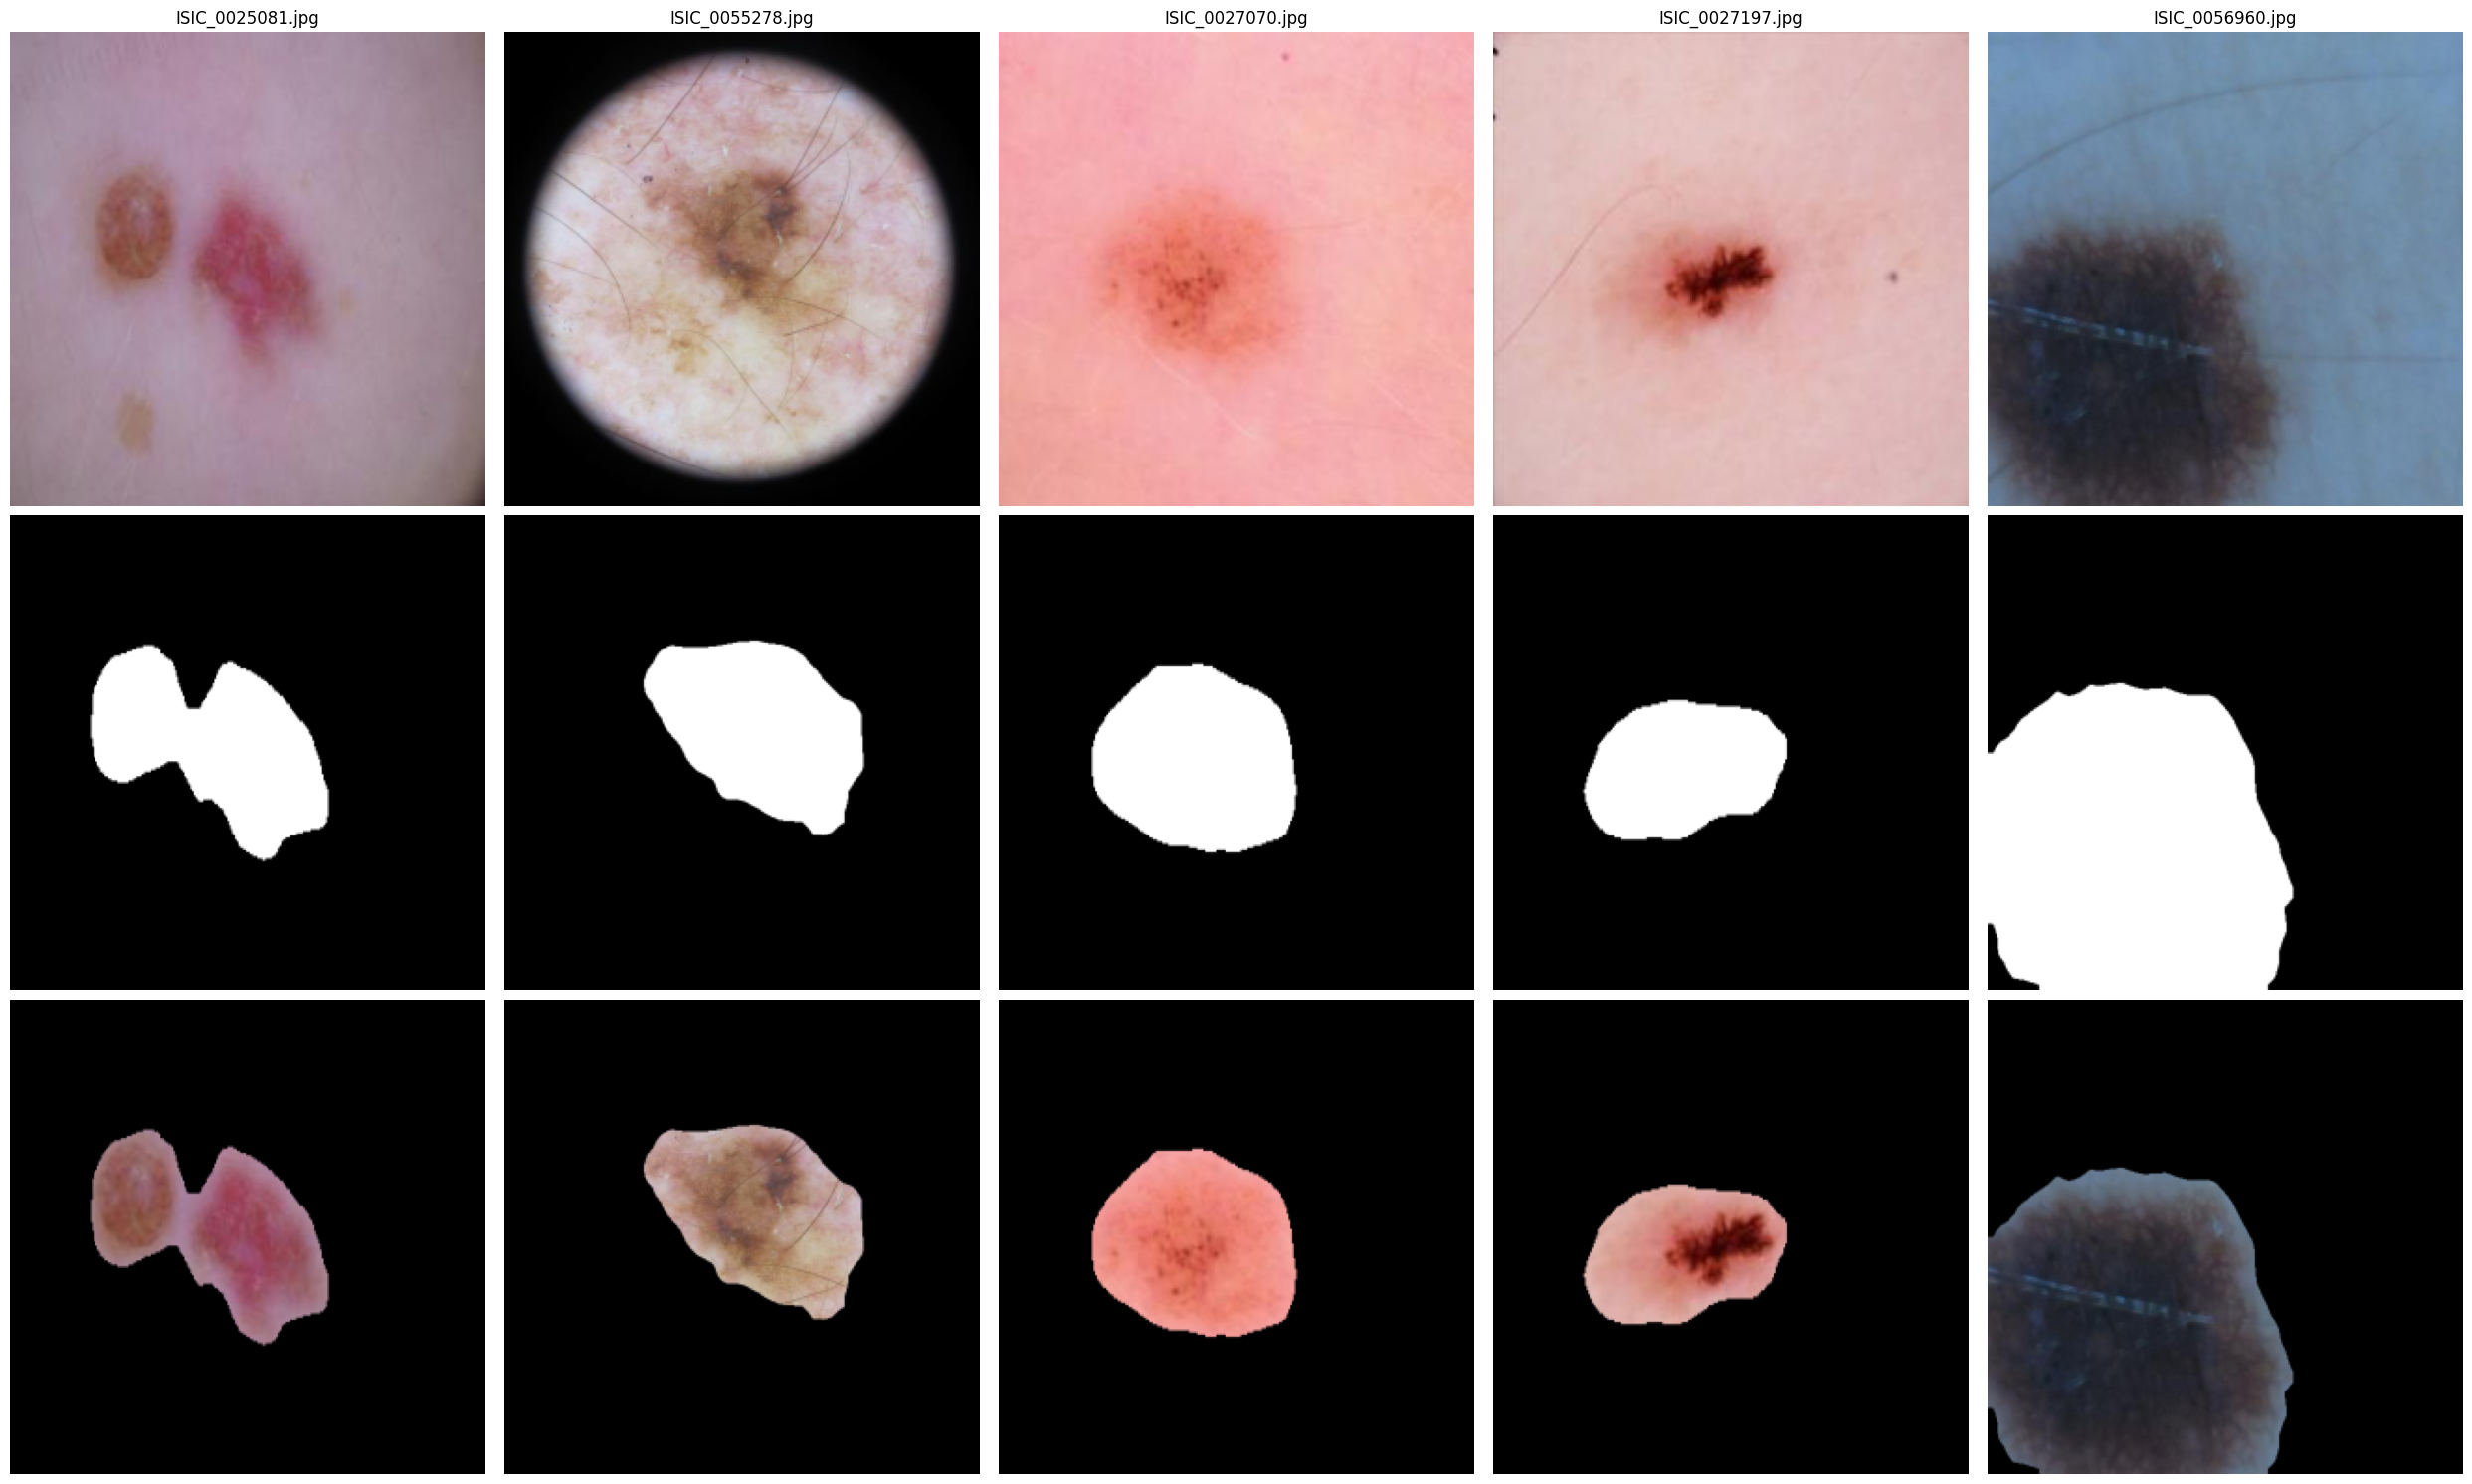

In [27]:
# Plot some segmenations
# Choose some IDs from Train/TrainImagesNoSeg
ex_ids = os.listdir(os.path.join(TRAIN_DIR, 'TrainImagesNoSeg'))

# Choose 5 random examples
ex_ids = np.random.choice(ex_ids, 5)

# Plot the images and their segmentation
fig, axs = plt.subplots(3, 5, figsize=(25, 15))

for i, ex_id in enumerate(ex_ids):
    # Load the image
    img = img_as_float(imread(os.path.join(TRAIN_DIR, 'TrainImagesNoSeg', ex_id)))
    # Resize the image
    img = resize(img, (256, 256))
    # Load the mask
    mask_filename = ex_id.split('.')[0] + '_seg.png'
    mask = img_as_float(imread(os.path.join(TRAIN_DIR, 'TrainMasks', mask_filename), as_gray=True))
    
    # Resize the mask
    mask = resize(mask, (256, 256))
    # Plot the image
    axs[0, i].imshow(img)
    axs[0, i].set_title(ex_id)
    axs[0, i].axis('off')
    # Plot the mask
    axs[1, i].imshow(mask, cmap='gray')
    axs[1, i].axis('off')
    # Plot the cropped image
    img_cropped = img * mask[:,:,np.newaxis]
    axs[2, i].imshow(img_cropped)
    axs[2, i].axis('off')

plt.tight_layout()
plt.show()

### Feature extraction

ABCD represent the asymmetry, border structure, variegated color, and dermatoscopical structures.


In [12]:
def calc_features(ID, img_dir, mask_dir):
    # Load the image and the mask
    img = imread(os.path.join(img_dir, f"{ID}.jpg"))
    mask = imread(os.path.join(mask_dir, f"{ID}_seg.png"), as_gray=True)
    # Ensure format
    img = img_as_float(img)
    mask = img_as_float(mask)
    # Calculate the features
    assymetry_features = calc_assymetry_features(mask)
    border_features = calc_border_features(img, mask)
    color_features = calc_colour_features(img, mask)
    texture_features = calc_texture_features(img, mask)
    # Combine the features
    features = {"ID":ID, **assymetry_features, **border_features, **color_features, **texture_features}
    return features

def calc_features_parallel(IDs, img_dir, mask_dir, threads=THREADS):
    features = Parallel(n_jobs=threads)(delayed(calc_features)(ID, img_dir, mask_dir) for ID in tqdm(IDs))
    return features

# Test the function
ID = 'ISIC_0000000'
img_dir = os.path.join(TRAIN_DIR, 'TrainImages')
mask_dir = os.path.join(TRAIN_DIR, 'TrainMasks')
features = calc_features(ID, img_dir, mask_dir)
print(len(features))
features

177


{'ID': 'ISIC_0000000',
 'AREA': 92002.0,
 'PERIMETER': 1345.4011537017761,
 'CIRCULARITY': 0.6387097428649782,
 'BULKINESS': 4.079485210445974,
 'SOLIDITY': 0.9680243263433675,
 'ECCENTRICITY': 0.7569104191424366,
 'BGRAD_R_MEAN': 0.0005962763654357645,
 'BGRAD_R_STD': 0.007793406906699909,
 'BGRAD_G_MEAN': 0.00035999257747262983,
 'BGRAD_G_STD': 0.011938427239336307,
 'BGRAD_B_MEAN': 0.0008090554833920955,
 'BGRAD_B_STD': 0.01747489246092262,
 'MEAN_R': 0.15762399994244275,
 'MEAN_G': 0.14314313053988717,
 'MEAN_B': 0.15340625119910978,
 'STD_R': 0.19414472623188336,
 'STD_G': 0.18622615364538936,
 'STD_B': 0.2011358530988799,
 'WEBER_MEAN': -0.003390038216797159,
 'WEBER_STD': 0.2452391862141668,
 'WEBER_HIST_1': 0.0,
 'WEBER_HIST_2': 3.567351598173516e-05,
 'WEBER_HIST_3': 0.0013810746901500325,
 'WEBER_HIST_4': 0.012210534898891063,
 'WEBER_HIST_5': 6.625081539465101e-05,
 'WEBER_HIST_6': 0.0014524217221135029,
 'WEBER_HIST_7': 2.0384866275277233e-05,
 'WEBER_HIST_8': 9.17318982387

In [13]:
# Load the train data into a pandas dataframe
# Data is in csv format in metadataTrain.csv
train_metadata_orig = pd.read_csv(os.path.join(TRAIN_DIR, 'metadataTrain.csv'))
train_metadata_orig

ID  CLASS     SEX   AGE         POSITION
0      ISIC_0028766      2    male  30.0              NaN
1      ISIC_0071222      8    male  85.0  lower extremity
2      ISIC_0069434      3    male  85.0        head/neck
3      ISIC_0062098      1    male  55.0        head/neck
4      ISIC_0057224      8  female  45.0  lower extremity
...             ...    ...     ...   ...              ...
18993  ISIC_0028726      2    male  40.0  posterior torso
18994  ISIC_0033160      2    male  30.0   anterior torso
18995  ISIC_0030034      1  female  50.0  posterior torso
18996  ISIC_0027095      2    male  50.0  lower extremity
18997  ISIC_0031967      5  female  70.0        head/neck

[18998 rows x 5 columns]

In [14]:
# Check for missing values
missing_values = train_metadata_orig.isnull().sum()
missing_values

ID             0
CLASS          0
SEX          284
AGE          324
POSITION    1970
dtype: int64

In [15]:
# Remove the rows with missing values
# Create a new dataframe without the rows with missing values
# train_metadata = train_metadata_orig.dropna()
# print(f"Number of rows dropped: {len(train_metadata_orig) - len(train_metadata)}")

# We'll fill only the missing "AGE" values with the median
mean_age = train_metadata_orig['AGE'].median()
train_metadata = train_metadata_orig.fillna({'AGE': mean_age})
train_metadata = train_metadata.fillna({'POSITION': 'unknown', 'SEX': 'unknown'})
train_metadata

ID  CLASS     SEX   AGE         POSITION
0      ISIC_0028766      2    male  30.0          unknown
1      ISIC_0071222      8    male  85.0  lower extremity
2      ISIC_0069434      3    male  85.0        head/neck
3      ISIC_0062098      1    male  55.0        head/neck
4      ISIC_0057224      8  female  45.0  lower extremity
...             ...    ...     ...   ...              ...
18993  ISIC_0028726      2    male  40.0  posterior torso
18994  ISIC_0033160      2    male  30.0   anterior torso
18995  ISIC_0030034      1  female  50.0  posterior torso
18996  ISIC_0027095      2    male  50.0  lower extremity
18997  ISIC_0031967      5  female  70.0        head/neck

[18998 rows x 5 columns]

In [16]:
# Check for missing values
missing_values = train_metadata.isnull().sum()
missing_values

ID          0
CLASS       0
SEX         0
AGE         0
POSITION    0
dtype: int64

In [17]:
sex_index = train_metadata.columns.get_loc("SEX")
position_index = train_metadata.columns.get_loc("POSITION")
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(sparse_output=False), 
                                      [sex_index, position_index])], 
                                      remainder='passthrough')

# Fit and transform the data
train_metadata_encoded = ct.fit_transform(train_metadata)
column_names = ct.get_feature_names_out()
train_metadata_encoded = pd.DataFrame(train_metadata_encoded, columns=column_names)
train_metadata_encoded = train_metadata_encoded.rename(columns={'remainder__ID': 'ID',
                                                                'remainder__AGE': 'AGE',
                                                                'remainder__CLASS': 'CLASS'})
train_metadata_encoded

encoder__SEX_female encoder__SEX_male encoder__SEX_unknown  \
0                     0.0               1.0                  0.0   
1                     0.0               1.0                  0.0   
2                     0.0               1.0                  0.0   
3                     0.0               1.0                  0.0   
4                     1.0               0.0                  0.0   
...                   ...               ...                  ...   
18993                 0.0               1.0                  0.0   
18994                 0.0               1.0                  0.0   
18995                 1.0               0.0                  0.0   
18996                 0.0               1.0                  0.0   
18997                 1.0               0.0                  0.0   

      encoder__POSITION_anterior torso encoder__POSITION_head/neck  \
0                                  0.0                         0.0   
1                                  0.0                         0.0   
2                                  0.0                         1.0   
3                                  0.0                         1.0   
4                                  0.0                         0.0   
...                                ...                         ...   
18993                              0.0                         0.0   
18994                              1.0                         0.0   
18995                              0.0                         0.0   
18996                              0.0                         0.0   
18997                              0.0                         1.0   

      encoder__POSITION_lateral torso encoder__POSITION_lower extremity  \
0                                 0.0                               0.0   
1                                 0.0                               1.0   
2                                 0.0                               0.0   
3                                 0.0                               0.0   
4                                 0.0                               1.0   
...                               ...                               ...   
18993                             0.0                               0.0   
18994                             0.0                               0.0   
18995                             0.0                               0.0   
18996                             0.0                               1.0   
18997                             0.0                               0.0   

      encoder__POSITION_oral/genital encoder__POSITION_palms/soles  \
0                                0.0                           0.0   
1                                0.0                           0.0   
2                                0.0                           0.0   
3                                0.0                           0.0   
4                                0.0                           0.0   
...                              ...                           ...   
18993                            0.0                           0.0   
18994                            0.0                           0.0   
18995                            0.0                           0.0   
18996                            0.0                           0.0   
18997                            0.0                           0.0   

      encoder__POSITION_posterior torso encoder__POSITION_unknown  \
0                                   0.0                       1.0   
1                                   0.0                       0.0   
2                                   0.0                       0.0   
3                                   0.0                       0.0   
4                                   0.0                       0.0   
...                                 ...                       ...   
18993                               1.0                       0.0   
18994                               0.0               

In [18]:
# Extract the IDs of the images
train_IDs = train_metadata['ID'].values

# Calculate the features for the train data
# First check if the features have already been calculated
if os.path.exists(os.path.join(TRAIN_DIR, 'train_features.csv')):
    train_features = pd.read_csv(os.path.join(TRAIN_DIR, 'train_features.csv'))
    print("Features already calculated.")
else:
    train_features = calc_features_parallel(train_IDs, os.path.join(TRAIN_DIR, 'TrainImages'),
                                            os.path.join(TRAIN_DIR, 'TrainMasks'), 
                                            threads=THREADS)

Features already calculated.


In [19]:
# Create a train dataframe with the features
train_df = pd.DataFrame(train_features)

# Save the train dataframe to a csv file for later use
train_df.to_csv(os.path.join(TRAIN_DIR, 'train_features.csv'), index=False)
train_df

ID     AREA    PERIMETER  CIRCULARITY  BULKINESS  SOLIDITY  \
0      ISIC_0028766   3209.0   228.024387     0.775563   4.114408  0.956198   
1      ISIC_0071222  23956.0   595.612265     0.848588   4.031006  0.982689   
2      ISIC_0069434  34095.0   829.595021     0.622541   4.493432  0.890558   
3      ISIC_0062098  16115.0   490.031529     0.843319   4.031188  0.976903   
4      ISIC_0057224    663.0   155.468037     0.344700   6.664345  0.631429   
...             ...      ...          ...          ...        ...       ...   
18993  ISIC_0028726  15924.0   509.688384     0.770287   4.017914  0.974183   
18994  ISIC_0033160   8593.0   372.391919     0.778671   4.020315  0.977477   
18995  ISIC_0030034  26542.0   683.251875     0.714466   4.159736  0.957711   
18996  ISIC_0027095   9847.0   409.747258     0.737024   4.040837  0.968240   
18997  ISIC_0031967  16893.0  1270.454978     0.131522   5.602648  0.623036   

       ECCENTRICITY  BGRAD_R_MEAN  BGRAD_R_STD  BGRAD_G_MEAN  ...  \
0          0.829791      0.000198     0.017501     -0.000852  ...   
1          0.570555     -0.000051     0.004218      0.000538  ...   
2          0.749933     -0.000412     0.006394      0.000950  ...   
3          0.451376      0.000488     0.020895      0.000324  ...   
4          0.953729     -0.000021     0.006699      0.000851  ...   
...             ...           ...          ...           ...  ...   
18993      0.812196      0.002128     0.009429      0.001227  ...   
18994      0.821906      0.001452     0.012512      0.001952  ...   
18995      0.796720     -0.000137     0.007526     -0.000025  ...   
18996      0.851763      0.000170     0.010427      0.001545  ...   
18997      0.862170      0.001997     0.008444      0.002134  ...   

       GLCM_ASM_11  GLCM_ASM_12  GLCM_ASM_13  GLCM_ASM_14  GLCM_ASM_15  \
0         0.901588     0.899921     0.896606     0.896049     0.899695   
1         0.821213     0.820832     0.818627     0.818259     0.819741   
2         0.749390     0.750370     0.750020     0.746722     0.746914   
3         0.876888     0.876878     0.875868     0.874806     0.875566   
4         0.993977     0.993996     0.993344     0.993118     0.993666   
...            ...          ...          ...          ...          ...   
18993     0.566346     0.569225     0.568381     0.558414     0.560479   
18994     0.747972     0.750792     0.749738     0.741533     0.743374   
18995     0.348968     0.348865     0.348893     0.344221     0.342532   
18996     0.718728     0.717804     0.711005     0.708157     0.715081   
18997     0.532355     0.533599     0.526716     0.519506     0.523322   

       GLCM_ASM_16  GLCM_ASM_17  GLCM_ASM_18  GLCM_ASM_19  GLCM_ASM_20  
0         0.896222     0.893927     0.892243     0.897787     0.892504  
1         0.818426     0.816872     0.815785     0.818265     0.816016  
2         0.747117     0.748313     0.743321     0.744435     0.743863  
3         0.874885     0.874637     0.872772     0.874241     0.872880  
4         0.993542     0.992986     0.992543     0.993354     0.993114  
...            ...          ...          ...          ...          ...  
18993     0.561863     0.564517     0.549865     0.554591     0.554494  
18994     0.745324     0.746736     0.734732     0.738774     0.739798  
18995     0.339186     0.344100     0.336213     0.336121     0.329535  
18996     0.711840     0.706331     0.700918     0.711412     0.705843  
18997     0.520382     0.518730     0.506948     0.514725     0.507907  

[18998 rows x 177 columns]

In [20]:
# Add the metadata to the train dataframe
train_df_merged = pd.merge(train_df, train_metadata_encoded, on='ID')
train_df_merged

ID     AREA    PERIMETER  CIRCULARITY  BULKINESS  SOLIDITY  \
0      ISIC_0028766   3209.0   228.024387     0.775563   4.114408  0.956198   
1      ISIC_0071222  23956.0   595.612265     0.848588   4.031006  0.982689   
2      ISIC_0069434  34095.0   829.595021     0.622541   4.493432  0.890558   
3      ISIC_0062098  16115.0   490.031529     0.843319   4.031188  0.976903   
4      ISIC_0057224    663.0   155.468037     0.344700   6.664345  0.631429   
...             ...      ...          ...          ...        ...       ...   
18993  ISIC_0028726  15924.0   509.688384     0.770287   4.017914  0.974183   
18994  ISIC_0033160   8593.0   372.391919     0.778671   4.020315  0.977477   
18995  ISIC_0030034  26542.0   683.251875     0.714466   4.159736  0.957711   
18996  ISIC_0027095   9847.0   409.747258     0.737024   4.040837  0.968240   
18997  ISIC_0031967  16893.0  1270.454978     0.131522   5.602648  0.623036   

       ECCENTRICITY  BGRAD_R_MEAN  BGRAD_R_STD  BGRAD_G_MEAN  ...  \
0          0.829791      0.000198     0.017501     -0.000852  ...   
1          0.570555     -0.000051     0.004218      0.000538  ...   
2          0.749933     -0.000412     0.006394      0.000950  ...   
3          0.451376      0.000488     0.020895      0.000324  ...   
4          0.953729     -0.000021     0.006699      0.000851  ...   
...             ...           ...          ...           ...  ...   
18993      0.812196      0.002128     0.009429      0.001227  ...   
18994      0.821906      0.001452     0.012512      0.001952  ...   
18995      0.796720     -0.000137     0.007526     -0.000025  ...   
18996      0.851763      0.000170     0.010427      0.001545  ...   
18997      0.862170      0.001997     0.008444      0.002134  ...   

       encoder__POSITION_head/neck  encoder__POSITION_lateral torso  \
0                              0.0                              0.0   
1                              0.0                              0.0   
2                              1.0                              0.0   
3                              1.0                              0.0   
4                              0.0                              0.0   
...                            ...                              ...   
18993                          0.0                              0.0   
18994                          0.0                              0.0   
18995                          0.0                              0.0   
18996                          0.0                              0.0   
18997                          1.0                              0.0   

       encoder__POSITION_lower extremity  encoder__POSITION_oral/genital  \
0                                    0.0                             0.0   
1                                    1.0                             0.0   
2                                    0.0                             0.0   
3                                    0.0                             0.0   
4                                    1.0                             0.0   
...                                  ...                             ...   
18993                                0.0                             0.0   
18994                                0.0                             0.0   
18995                                0.0                             0.0   
18996                                1.0                             0.0   
18997                                0.0                             0.0   

       encoder__POSITION_palms/soles  encoder__POSITION_posterior torso  \
0                                0.0                                0.0   
1                                0.0                                0.0   
2                                0.0                                0.0   
3                                0.0                                0.0   
4                                0.0                                0.0   
...                    

In [21]:
# Drop the columnns corresponding to one-hot encoded unknown values
train_df_merged = train_df_merged.drop(columns=['encoder__POSITION_unknown', 'encoder__SEX_unknown'])

In [22]:
# Scale the features

# Scale the features, excluding 'ID' and 'CLASS'
scaler = StandardScaler()
# Select the columns to scale
columns_to_scale = train_df_merged.drop(columns=['ID', 'CLASS']).columns
# Apply scaling
train_df_scaled = scaler.fit_transform(train_df_merged[columns_to_scale])
# Create a DataFrame from the scaled data
train_df_scaled = pd.DataFrame(train_df_scaled, columns=columns_to_scale, index=train_df_merged.index)

# Add the 'ID' and 'CLASS' columns back to the scaled DataFrame
train_df_scaled['ID'] = train_df_merged['ID']
train_df_scaled['CLASS'] = train_df_merged['CLASS']

# Reorder the columns to place 'ID' and 'CLASS' appropriately, if needed
columns_order = ['ID'] + list(columns_to_scale) + ['CLASS']
train_df_scaled = train_df_scaled[columns_order]

train_df_scaled

ID      AREA  PERIMETER  CIRCULARITY  BULKINESS  SOLIDITY  \
0      ISIC_0028766 -0.885894  -1.206715     0.455835  -0.045869  0.308294   
1      ISIC_0071222 -0.490389  -0.512278     0.887260  -0.052733  0.545368   
2      ISIC_0069434 -0.297107  -0.070243    -0.448198  -0.014678 -0.279127   
3      ISIC_0062098 -0.639864  -0.711738     0.856133  -0.052718  0.493590   
4      ISIC_0057224 -0.934429  -1.343787    -2.089654   0.163974 -2.598097   
...             ...       ...        ...          ...        ...       ...   
18993  ISIC_0028726 -0.643505  -0.674603     0.424666  -0.053810  0.469247   
18994  ISIC_0033160 -0.783257  -0.933980     0.474200  -0.053613  0.498722   
18995  ISIC_0030034 -0.441091  -0.346711     0.094885  -0.042139  0.321834   
18996  ISIC_0027095 -0.759352  -0.863409     0.228153  -0.051924  0.416059   
18997  ISIC_0031967 -0.625032   0.762618    -3.349085   0.076603 -2.673202   

       ECCENTRICITY  BGRAD_R_MEAN  BGRAD_R_STD  BGRAD_G_MEAN  ...  \
0          1.251235      0.096181     0.859086     -0.383293  ...   
1         -0.384853     -0.018345    -0.830774      0.222550  ...   
2          0.747236     -0.184185    -0.553962      0.402201  ...   
3         -1.137009      0.229236     1.290933      0.129393  ...   
4          2.033431     -0.004517    -0.515192      0.359032  ...   
...             ...           ...          ...           ...  ...   
18993      1.140192      0.983456    -0.167904      0.522961  ...   
18994      1.201474      0.672470     0.224413      0.839162  ...   
18995      1.042518     -0.057772    -0.409931     -0.022979  ...   
18996      1.389906      0.083331    -0.040914      0.661680  ...   
18997      1.455584      0.923286    -0.293131      0.918536  ...   

       encoder__POSITION_anterior torso  encoder__POSITION_head/neck  \
0                             -0.613407                    -0.470805   
1                             -0.613407                    -0.470805   
2                             -0.613407                     2.124020   
3                             -0.613407                     2.124020   
4                             -0.613407                    -0.470805   
...                                 ...                          ...   
18993                         -0.613407                    -0.470805   
18994                          1.630240                    -0.470805   
18995                         -0.613407                    -0.470805   
18996                         -0.613407                    -0.470805   
18997                         -0.613407                     2.124020   

       encoder__POSITION_lateral torso  encoder__POSITION_lower extremity  \
0                            -0.047071                          -0.494928   
1                            -0.047071                           2.020494   
2                            -0.047071                          -0.494928   
3                            -0.047071                          -0.494928   
4                            -0.047071                           2.020494   
...                                ...                                ...   
18993                        -0.047071                          -0.494928   
18994                        -0.047071                          -0.494928   
18995                        -0.047071                          -0.494928   
18996                        -0.047071                           2.020494   
18997                        -0.047071                          -0.494928   

       encoder__POSITION_oral/genital  encoder__POSITION_palms/soles  \
0                           -0.049266                       -0.12494   
1                           -0.049266                       -0.12494   
2                           -0.049266                       -0.12494   
3                           -0.049266                       -0.12494   
4                           -0.049266                       -0.12494   
...                          

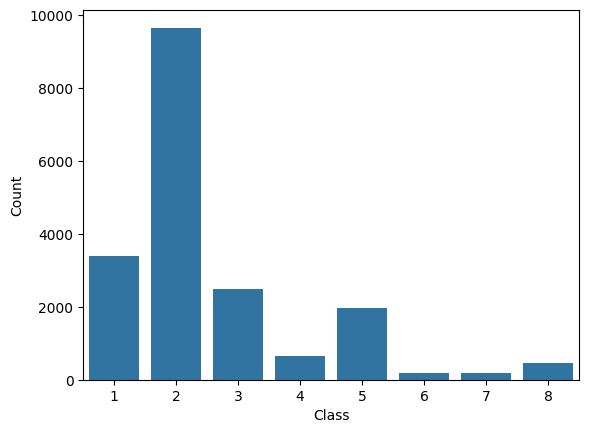

In [23]:
# Make a histogram of the classes in the test data
sns.countplot(data=train_df_scaled, x='CLASS')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [24]:
# We will fix the imbalance of the classes using ADAptive SYNthetic oversampling (ADASYN)

# Extract the features and the target
X_train = train_df_scaled.drop(columns=['ID', 'CLASS'])
# y_train = train_df_scaled['CLASS'].astype(int)
y_train = train_df_scaled['CLASS'].to_numpy().astype(int)

# Apply ADASYN
knn = NearestNeighbors(n_neighbors=5, n_jobs=THREADS)
adasyn = ADASYN(random_state=42, n_neighbors=knn)
X_train, y_train = adasyn.fit_resample(X_train, y_train)

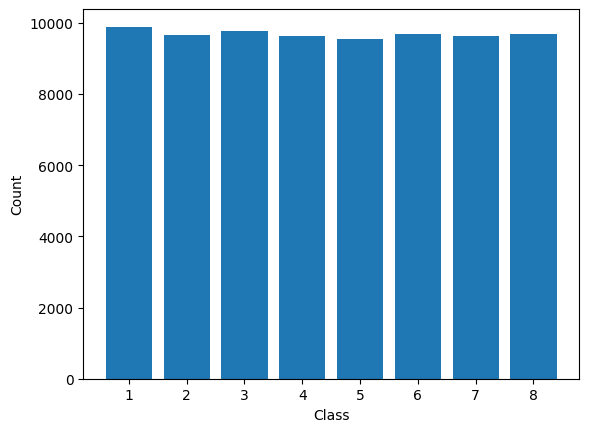

In [25]:
# Make a histogram of the classes in the test data
histo = np.unique(y_train, return_counts=True)

plt.bar(histo[0], histo[1])
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [26]:
# Now we need to predict the class of the test data
# Load the test data into a pandas dataframe
# Data is in csv format in metadataTest.csv
test_metadata_orig = pd.read_csv(os.path.join(TEST_DIR, 'metadataTest.csv'))
test_metadata_orig

ID     SEX   AGE         POSITION
0     ISIC_0055289  female  50.0  lower extremity
1     ISIC_0062682    male  65.0  lower extremity
2     ISIC_0057706  female  75.0              NaN
3     ISIC_0031702    male  70.0        head/neck
4     ISIC_0069272    male  60.0  lower extremity
...            ...     ...   ...              ...
6328  ISIC_0028560    male  85.0  upper extremity
6329  ISIC_0068188  female  75.0  upper extremity
6330  ISIC_0072611  female  50.0      palms/soles
6331  ISIC_0032918    male  50.0        head/neck
6332  ISIC_0069398  female  30.0   anterior torso

[6333 rows x 4 columns]

In [27]:
# Check for missing values
missing_values = test_metadata_orig.isnull().sum()
missing_values

ID            0
SEX         100
AGE         113
POSITION    661
dtype: int64

In [28]:
# We'll fill only the missing "AGE" values with the mean
mean_age = test_metadata_orig['AGE'].mean()
test_metadata = test_metadata_orig.fillna({'AGE': mean_age})
test_metadata = test_metadata.fillna({'POSITION': 'unknown', 'SEX': 'unknown'})
test_metadata

ID     SEX   AGE         POSITION
0     ISIC_0055289  female  50.0  lower extremity
1     ISIC_0062682    male  65.0  lower extremity
2     ISIC_0057706  female  75.0          unknown
3     ISIC_0031702    male  70.0        head/neck
4     ISIC_0069272    male  60.0  lower extremity
...            ...     ...   ...              ...
6328  ISIC_0028560    male  85.0  upper extremity
6329  ISIC_0068188  female  75.0  upper extremity
6330  ISIC_0072611  female  50.0      palms/soles
6331  ISIC_0032918    male  50.0        head/neck
6332  ISIC_0069398  female  30.0   anterior torso

[6333 rows x 4 columns]

In [29]:
# Check for missing values
missing_values = test_metadata.isnull().sum()
missing_values

ID          0
SEX         0
AGE         0
POSITION    0
dtype: int64

In [30]:
# Encode the metadata

# Add a CLASS column to the test metadata with a dummy value
test_metadata['CLASS'] = 0

# Encode the metadata
test_metadata_encoded = ct.transform(test_metadata)
test_metadata_encoded = pd.DataFrame(test_metadata_encoded, columns=column_names)
test_metadata_encoded = test_metadata_encoded.rename(columns={'remainder__ID': 'ID',
                                                              'remainder__AGE': 'AGE'})

# Drop the dummy CLASS column
test_metadata_encoded = test_metadata_encoded.drop(columns=['remainder__CLASS'])

test_metadata_encoded

encoder__SEX_female encoder__SEX_male encoder__SEX_unknown  \
0                    1.0               0.0                  0.0   
1                    0.0               1.0                  0.0   
2                    1.0               0.0                  0.0   
3                    0.0               1.0                  0.0   
4                    0.0               1.0                  0.0   
...                  ...               ...                  ...   
6328                 0.0               1.0                  0.0   
6329                 1.0               0.0                  0.0   
6330                 1.0               0.0                  0.0   
6331                 0.0               1.0                  0.0   
6332                 1.0               0.0                  0.0   

     encoder__POSITION_anterior torso encoder__POSITION_head/neck  \
0                                 0.0                         0.0   
1                                 0.0                         0.0   
2                                 0.0                         0.0   
3                                 0.0                         1.0   
4                                 0.0                         0.0   
...                               ...                         ...   
6328                              0.0                         0.0   
6329                              0.0                         0.0   
6330                              0.0                         0.0   
6331                              0.0                         1.0   
6332                              1.0                         0.0   

     encoder__POSITION_lateral torso encoder__POSITION_lower extremity  \
0                                0.0                               1.0   
1                                0.0                               1.0   
2                                0.0                               0.0   
3                                0.0                               0.0   
4                                0.0                               1.0   
...                              ...                               ...   
6328                             0.0                               0.0   
6329                             0.0                               0.0   
6330                             0.0                               0.0   
6331                             0.0                               0.0   
6332                             0.0                               0.0   

     encoder__POSITION_oral/genital encoder__POSITION_palms/soles  \
0                               0.0                           0.0   
1                               0.0                           0.0   
2                               0.0                           0.0   
3                               0.0                           0.0   
4                               0.0                           0.0   
...                             ...                           ...   
6328                            0.0                           0.0   
6329                            0.0                           0.0   
6330                            0.0                           1.0   
6331                            0.0                           0.0   
6332                            0.0                           0.0   

     encoder__POSITION_posterior torso encoder__POSITION_unknown  \
0                                  0.0                       0.0   
1                                  0.0                       0.0   
2                                  0.0                       1.0   
3                                  0.0                       0.0   
4                                  0.0                       0.0   
...                                ...                       ...   
6328                               0.0                       0.0   
6329                               0.0                       0.0   
6330                               0.0   

In [31]:
# Drop the columnns corresponding to one-hot encoded unknown values
test_metadata_encoded = test_metadata_encoded.drop(columns=['encoder__POSITION_unknown', 'encoder__SEX_unknown'])

# Extract the IDs of the images
test_IDs = test_metadata['ID'].values

# Calculate the features for the test data
# First check if the features have already been calculated
if os.path.exists(os.path.join(TEST_DIR, 'test_features.csv')):
    test_features = pd.read_csv(os.path.join(TEST_DIR, 'test_features.csv'))
    print("Features already calculated.")
else:
    test_features = calc_features_parallel(test_IDs, os.path.join(TEST_DIR, 'TestImages'), 
                                        os.path.join(TEST_DIR, 'TestMasks'), 
                                        threads=THREADS)

# Create a test dataframe with the features
test_df = pd.DataFrame(test_features)

# Save the test dataframe to a csv file for later use
test_df.to_csv(os.path.join(TEST_DIR, 'test_features.csv'), index=False)
test_df

Features already calculated.


ID      AREA    PERIMETER  CIRCULARITY  BULKINESS  SOLIDITY  \
0     ISIC_0055289   89781.0  1208.915872     0.771973   4.062491  0.964288   
1     ISIC_0062682   88958.0  1345.307791     0.617663   4.117654  0.931556   
2     ISIC_0057706     917.0   175.509668     0.374091  31.832511  0.138666   
3     ISIC_0031702    7147.0   335.806133     0.796446   4.044377  0.944995   
4     ISIC_0069272  136659.0  1708.354473     0.588426   4.224325  0.917205   
...            ...       ...          ...          ...        ...       ...   
6328  ISIC_0028560    2133.0   344.977705     0.225226  10.176045  0.439975   
6329  ISIC_0068188   84292.0  1135.224530     0.821926   4.023535  0.973191   
6330  ISIC_0072611   19967.0   533.002092     0.883212   4.025584  0.988808   
6331  ISIC_0032918   13616.0   455.244733     0.825600   4.098481  0.973475   
6332  ISIC_0069398   53755.0  1632.279400     0.253536   4.885148  0.696056   

      ECCENTRICITY  BGRAD_R_MEAN  BGRAD_R_STD  BGRAD_G_MEAN  ...  GLCM_ASM_11  \
0         0.667154      0.000152     0.004781      0.000203  ...     0.424352   
1         0.562224      0.000017     0.004203      0.000203  ...     0.428378   
2         0.900818     -0.002698     0.013800     -0.001176  ...     0.991813   
3         0.459206     -0.000520     0.020856      0.000515  ...     0.789194   
4         0.649337     -0.000209     0.017995     -0.000698  ...     0.223481   
...            ...           ...          ...           ...  ...          ...   
6328      0.645575     -0.002614     0.016764     -0.003004  ...     0.927030   
6329      0.209750     -0.000082     0.010127      0.000052  ...     0.452195   
6330      0.465030     -0.000643     0.005839     -0.000600  ...     0.849139   
6331      0.445324     -0.000500     0.009951      0.000122  ...     0.623288   
6332      0.873055      0.000401     0.003080      0.000283  ...     0.621048   

      GLCM_ASM_12  GLCM_ASM_13  GLCM_ASM_14  GLCM_ASM_15  GLCM_ASM_16  \
0        0.424309     0.421674     0.418030     0.421659     0.420245   
1        0.427199     0.424491     0.423259     0.425555     0.422371   
2        0.991835     0.991177     0.991081     0.991437     0.991257   
3        0.788866     0.785465     0.783161     0.785755     0.783483   
4        0.221629     0.217955     0.216870     0.221491     0.217752   
...           ...          ...          ...          ...          ...   
6328     0.927452     0.925498     0.923682     0.923457     0.922284   
6329     0.451999     0.449810     0.447827     0.449470     0.447807   
6330     0.849034     0.848025     0.846907     0.847685     0.846793   
6331     0.623082     0.619219     0.615739     0.618578     0.615906   
6332     0.620869     0.617628     0.615800     0.617414     0.615336   

      GLCM_ASM_17  GLCM_ASM_18  GLCM_ASM_19  GLCM_ASM_20  
0        0.418994     0.413242     0.418969     0.416186  
1        0.421433     0.418775     0.422767     0.417600  
2        0.990753     0.990459     0.991067     0.990729  
3        0.781929     0.777690     0.782319     0.778121  
4        0.215134     0.212785     0.219519     0.213958  
...           ...          ...          ...          ...  
6328     0.922471     0.919071     0.919888     0.917256  
6329     0.447173     0.443667     0.446751     0.443621  
6330     0.846653     0.844696     0.846227     0.844540  
6331     0.614677     0.608480     0.613843     0.608671  
6332     0.614117     0.610504     0.613864     0.609906  

[6333 rows x 177 columns]

In [32]:
# Add the metadata to the test dataframe
test_df_merged = pd.merge(test_df, test_metadata_encoded, on='ID')
test_df_merged

ID      AREA    PERIMETER  CIRCULARITY  BULKINESS  SOLIDITY  \
0     ISIC_0055289   89781.0  1208.915872     0.771973   4.062491  0.964288   
1     ISIC_0062682   88958.0  1345.307791     0.617663   4.117654  0.931556   
2     ISIC_0057706     917.0   175.509668     0.374091  31.832511  0.138666   
3     ISIC_0031702    7147.0   335.806133     0.796446   4.044377  0.944995   
4     ISIC_0069272  136659.0  1708.354473     0.588426   4.224325  0.917205   
...            ...       ...          ...          ...        ...       ...   
6328  ISIC_0028560    2133.0   344.977705     0.225226  10.176045  0.439975   
6329  ISIC_0068188   84292.0  1135.224530     0.821926   4.023535  0.973191   
6330  ISIC_0072611   19967.0   533.002092     0.883212   4.025584  0.988808   
6331  ISIC_0032918   13616.0   455.244733     0.825600   4.098481  0.973475   
6332  ISIC_0069398   53755.0  1632.279400     0.253536   4.885148  0.696056   

      ECCENTRICITY  BGRAD_R_MEAN  BGRAD_R_STD  BGRAD_G_MEAN  ...  \
0         0.667154      0.000152     0.004781      0.000203  ...   
1         0.562224      0.000017     0.004203      0.000203  ...   
2         0.900818     -0.002698     0.013800     -0.001176  ...   
3         0.459206     -0.000520     0.020856      0.000515  ...   
4         0.649337     -0.000209     0.017995     -0.000698  ...   
...            ...           ...          ...           ...  ...   
6328      0.645575     -0.002614     0.016764     -0.003004  ...   
6329      0.209750     -0.000082     0.010127      0.000052  ...   
6330      0.465030     -0.000643     0.005839     -0.000600  ...   
6331      0.445324     -0.000500     0.009951      0.000122  ...   
6332      0.873055      0.000401     0.003080      0.000283  ...   

      encoder__SEX_male  encoder__POSITION_anterior torso  \
0                   0.0                               0.0   
1                   1.0                               0.0   
2                   0.0                               0.0   
3                   1.0                               0.0   
4                   1.0                               0.0   
...                 ...                               ...   
6328                1.0                               0.0   
6329                0.0                               0.0   
6330                0.0                               0.0   
6331                1.0                               0.0   
6332                0.0                               1.0   

      encoder__POSITION_head/neck  encoder__POSITION_lateral torso  \
0                             0.0                              0.0   
1                             0.0                              0.0   
2                             0.0                              0.0   
3                             1.0                              0.0   
4                             0.0                              0.0   
...                           ...                              ...   
6328                          0.0                              0.0   
6329                          0.0                              0.0   
6330                          0.0                              0.0   
6331                          1.0                              0.0   
6332                          0.0                              0.0   

      encoder__POSITION_lower extremity  encoder__POSITION_oral/genital  \
0                                   1.0                             0.0   
1                                   1.0                             0.0   
2                                   0.0                             0.0   
3                                   0.0                             0.0   
4                                   1.0                             0.0   
...                                 ...                             ...   
6328                                0.0                             0.0   
6329                                0.0                             0.0   
6

In [33]:
# Scale the test features
test_df_scaled = scaler.transform(test_df_merged.drop(columns=['ID']))
test_df_scaled = pd.DataFrame(test_df_scaled, columns=test_df_merged.columns[1:])
test_df_scaled['ID'] = test_df_merged['ID']
test_df_scaled

AREA  PERIMETER  CIRCULARITY  BULKINESS  SOLIDITY  ECCENTRICITY  \
0     0.764449   0.646360     0.434627  -0.050142  0.380693      0.224805   
1     0.748760   0.904028    -0.477019  -0.045602  0.087771     -0.437428   
2    -0.929587  -1.305925    -1.916015   2.235145 -7.007872      1.699498   
3    -0.810823  -1.003097     0.579211  -0.051632  0.208042     -1.087597   
4     1.658095   1.589887    -0.649746  -0.036824 -0.040655      0.112357   
...        ...        ...          ...        ...       ...           ...   
6328 -0.906406  -0.985770    -2.795492   0.452963 -4.311430      0.088616   
6329  0.659811   0.507144     0.729743  -0.053348  0.460370     -2.661956   
6330 -0.566432  -0.630559     1.091813  -0.053179  0.600125     -1.050837   
6331 -0.687503  -0.777456     0.751447  -0.047180  0.462912     -1.175205   
6332  0.077677   1.446168    -2.628239   0.017557 -2.019741      1.524285   

      BGRAD_R_MEAN  BGRAD_R_STD  BGRAD_G_MEAN  BGRAD_G_STD  ...  \
0         0.074849    -0.759161      0.076417    -0.703171  ...   
1         0.012741    -0.832738      0.076489    -0.920527  ...   
2        -1.235389     0.388193     -0.524815     0.509227  ...   
3        -0.234187     1.285898      0.212876     1.318474  ...   
4        -0.091073     0.921950     -0.316190     0.703948  ...   
...            ...          ...           ...          ...  ...   
6328     -1.196927     0.765378     -1.321720     1.222273  ...   
6329     -0.032833    -0.079112      0.010637    -0.207390  ...   
6330     -0.290748    -0.624608     -0.273580    -0.522701  ...   
6331     -0.224762    -0.101459      0.041460    -0.162780  ...   
6332      0.189231    -0.975645      0.111615    -1.067741  ...   

      encoder__POSITION_anterior torso  encoder__POSITION_head/neck  \
0                            -0.613407                    -0.470805   
1                            -0.613407                    -0.470805   
2                            -0.613407                    -0.470805   
3                            -0.613407                     2.124020   
4                            -0.613407                    -0.470805   
...                                ...                          ...   
6328                         -0.613407                    -0.470805   
6329                         -0.613407                    -0.470805   
6330                         -0.613407                    -0.470805   
6331                         -0.613407                     2.124020   
6332                          1.630240                    -0.470805   

      encoder__POSITION_lateral torso  encoder__POSITION_lower extremity  \
0                           -0.047071                           2.020494   
1                           -0.047071                           2.020494   
2                           -0.047071                          -0.494928   
3                           -0.047071                          -0.494928   
4                           -0.047071                           2.020494   
...                               ...                                ...   
6328                        -0.047071                          -0.494928   
6329                        -0.047071                          -0.494928   
6330                        -0.047071                          -0.494928   
6331                        -0.047071                          -0.494928   
6332                        -0.047071                          -0.494928   

      encoder__POSITION_oral/genital  encoder__POSITION_palms/soles  \
0                          -0.049266                      -0.124940   
1                          -0.049266                      -0.124940   
2                          -0.049266                      -0.124940   
3                          -0.049266                      -0.124940   
4                          -0.049266                      -0.124940   
...                              ...                            ...   
6328             

### Classification

In [41]:
X_train_features = X_train.to_numpy()
y_train_features = y_train.astype(int)

X_test_features = test_df_scaled.drop(columns=['ID']).to_numpy()

class_weights = {
    1: 0.7005531,
    2: 0.24592265,
    3: 0.95261733,
    4: 3.64804147,
    5: 1.20674543,
    6: 13.19375,
    7: 12.56547619,
    8: 5.04219745
}

class_weights_nn = {
    0: 0.7005531,
    1: 0.24592265,
    2: 0.95261733,
    3: 3.64804147,
    4: 1.20674543,
    5: 13.19375,
    6: 12.56547619,
    7: 5.04219745
}

In [35]:
# Save X_train, y_train, and X_test to files
np.save(os.path.join(TRAIN_DIR, 'X_train_features.npy'), X_train_features)
np.save(os.path.join(TRAIN_DIR, 'y_train_features.npy'), y_train_features)
np.save(os.path.join(TEST_DIR, 'X_test_features.npy'), X_test_features)

In [ ]:
parameters = {
    'C': [10, 50, 100],
    'gamma': [0.001, 0.01, 0.1],
    'kernel': ['rbf']
}

grid_search = GridSearchCV(SVC(class_weight=class_weights), 
                           param_grid=parameters, cv=4, scoring='f1_weighted', 
                           n_jobs=THREADS, verbose=4)

# Execute the grid search
grid_search.fit(X_train_features, y_train_features)

best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")
print(f"Best score: {grid_search.best_score_:.4f}")

In [ ]:
# Fit the model with the best parameters
svm_best = SVC(**best_params)
svm_best.fit(X_train, y_train)

# Predict the class of the test data
y_pred = svm_best.predict(X_test_features)

# Output the predictions with their ID to a csv file
output = pd.DataFrame({'ID': test_df_scaled['ID'], 'CLASS': y_pred})
output.to_csv('predictions_SVM.csv', index=False)
print(output.shape)

Model not found - creating a new one.


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_45 (Dense)                │ (None, 150)            │        28,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 150)            │           600 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 150)            │        22,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 150)            │           600 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 8)              │         1,208 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,258 (208.04 KB)

 Trainable params: 52,658 (205.70 KB)

 Non-trainable params: 600 (2.34 KB)

Epoch 1/1000
646/646 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.3416 - loss: 3.4512 - val_accuracy: 0.3047 - val_loss: 2.5218 - learning_rate: 0.0100
Epoch 2/1000
646/646 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4387 - loss: 2.1970 - val_accuracy: 0.3581 - val_loss: 2.3086 - learning_rate: 0.0100
Epoch 3/1000
646/646 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4887 - loss: 1.8549 - val_accuracy: 0.3364 - val_loss: 2.0557 - learning_rate: 0.0100
Epoch 4/1000
646/646 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5113 - loss: 1.7063 - val_accuracy: 0.3629 - val_loss: 2.1580 - learning_rate: 0.0100
Epoch 5/1000
646/646 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5305 - loss: 1.5851 - val_accuracy: 0.3599 - val_loss: 2.3319 - learning_rate: 0.0100
Epoch 6/1000
646/646 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5499 - loss: 1.4769 - val_accuracy: 0.3810 - val_loss: 1.9972 - learning_rate: 0.0100
Epoch 7/1000
646/646 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5692 - l

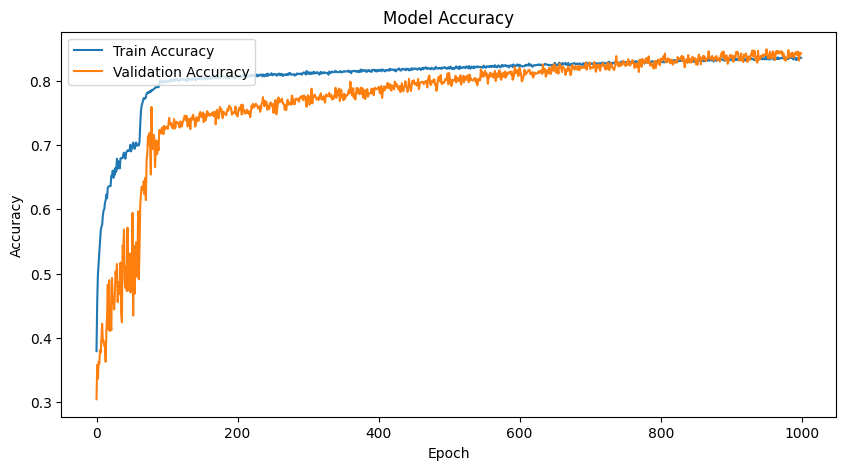

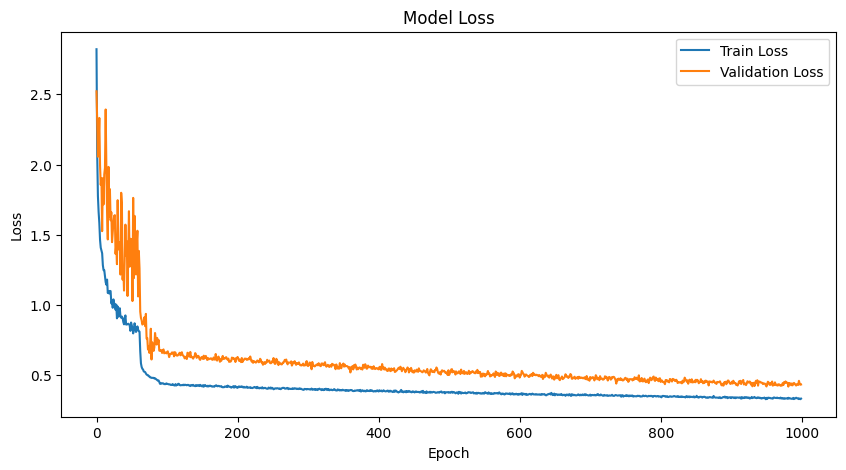

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
(6333, 2)


In [66]:
# If there's a saved model you can load it
if os.path.exists('best_model_MLP.keras'):
    model = tf.keras.models.load_model('best_model_MLP.keras')
    model.summary()
    print("Model loaded.")
else:
    print("Model not found - creating a new one.")

    model = Sequential([
        Input(shape=(X_train.shape[1],), name='input'),
        Dense(150, activation='relu', name='hidden1'),
        BatchNormalization(name='batchnorm1'),
        Dropout(0.1, name='dropout1'),
        Dense(150, activation='relu', name='hidden2'),
        BatchNormalization(name='batchnorm2'),
        Dropout(0.1, name='dropout2'),
        Dense(8, activation='softmax', name='output')
    ])

    optimizer = AdamW(learning_rate=0.01)

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-4, verbose=1)

    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    model.summary()

    # Train the model with EarlyStopping and capture the history
    history = model.fit(
        X_train, y_train - 1,  # assuming y_train needs adjusting based on your earlier code
        epochs=1000,
        batch_size=96,
        validation_split=0.2,
        callbacks=[reduce_lr],  # and any other callbacks like learning rate schedulers
        class_weight=class_weights_nn  # add class weights here
    )

    # Save the best MLP found to a file
    model.save('best_model_MLP.keras')

    # Plotting the training accuracy and validation accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

    # If you also want to plot the loss, you can do so with a similar approach:
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

# Predict the class of the test data
y_pred = model.predict(X_test_features)
y_pred = np.argmax(y_pred, axis=1) + 1

# Output the predictions with their ID to a csv file
output = pd.DataFrame({'ID': test_df_scaled['ID'], 'CLASS': y_pred})
output.to_csv('predictions_MLP.csv', index=False)
print(output.shape)

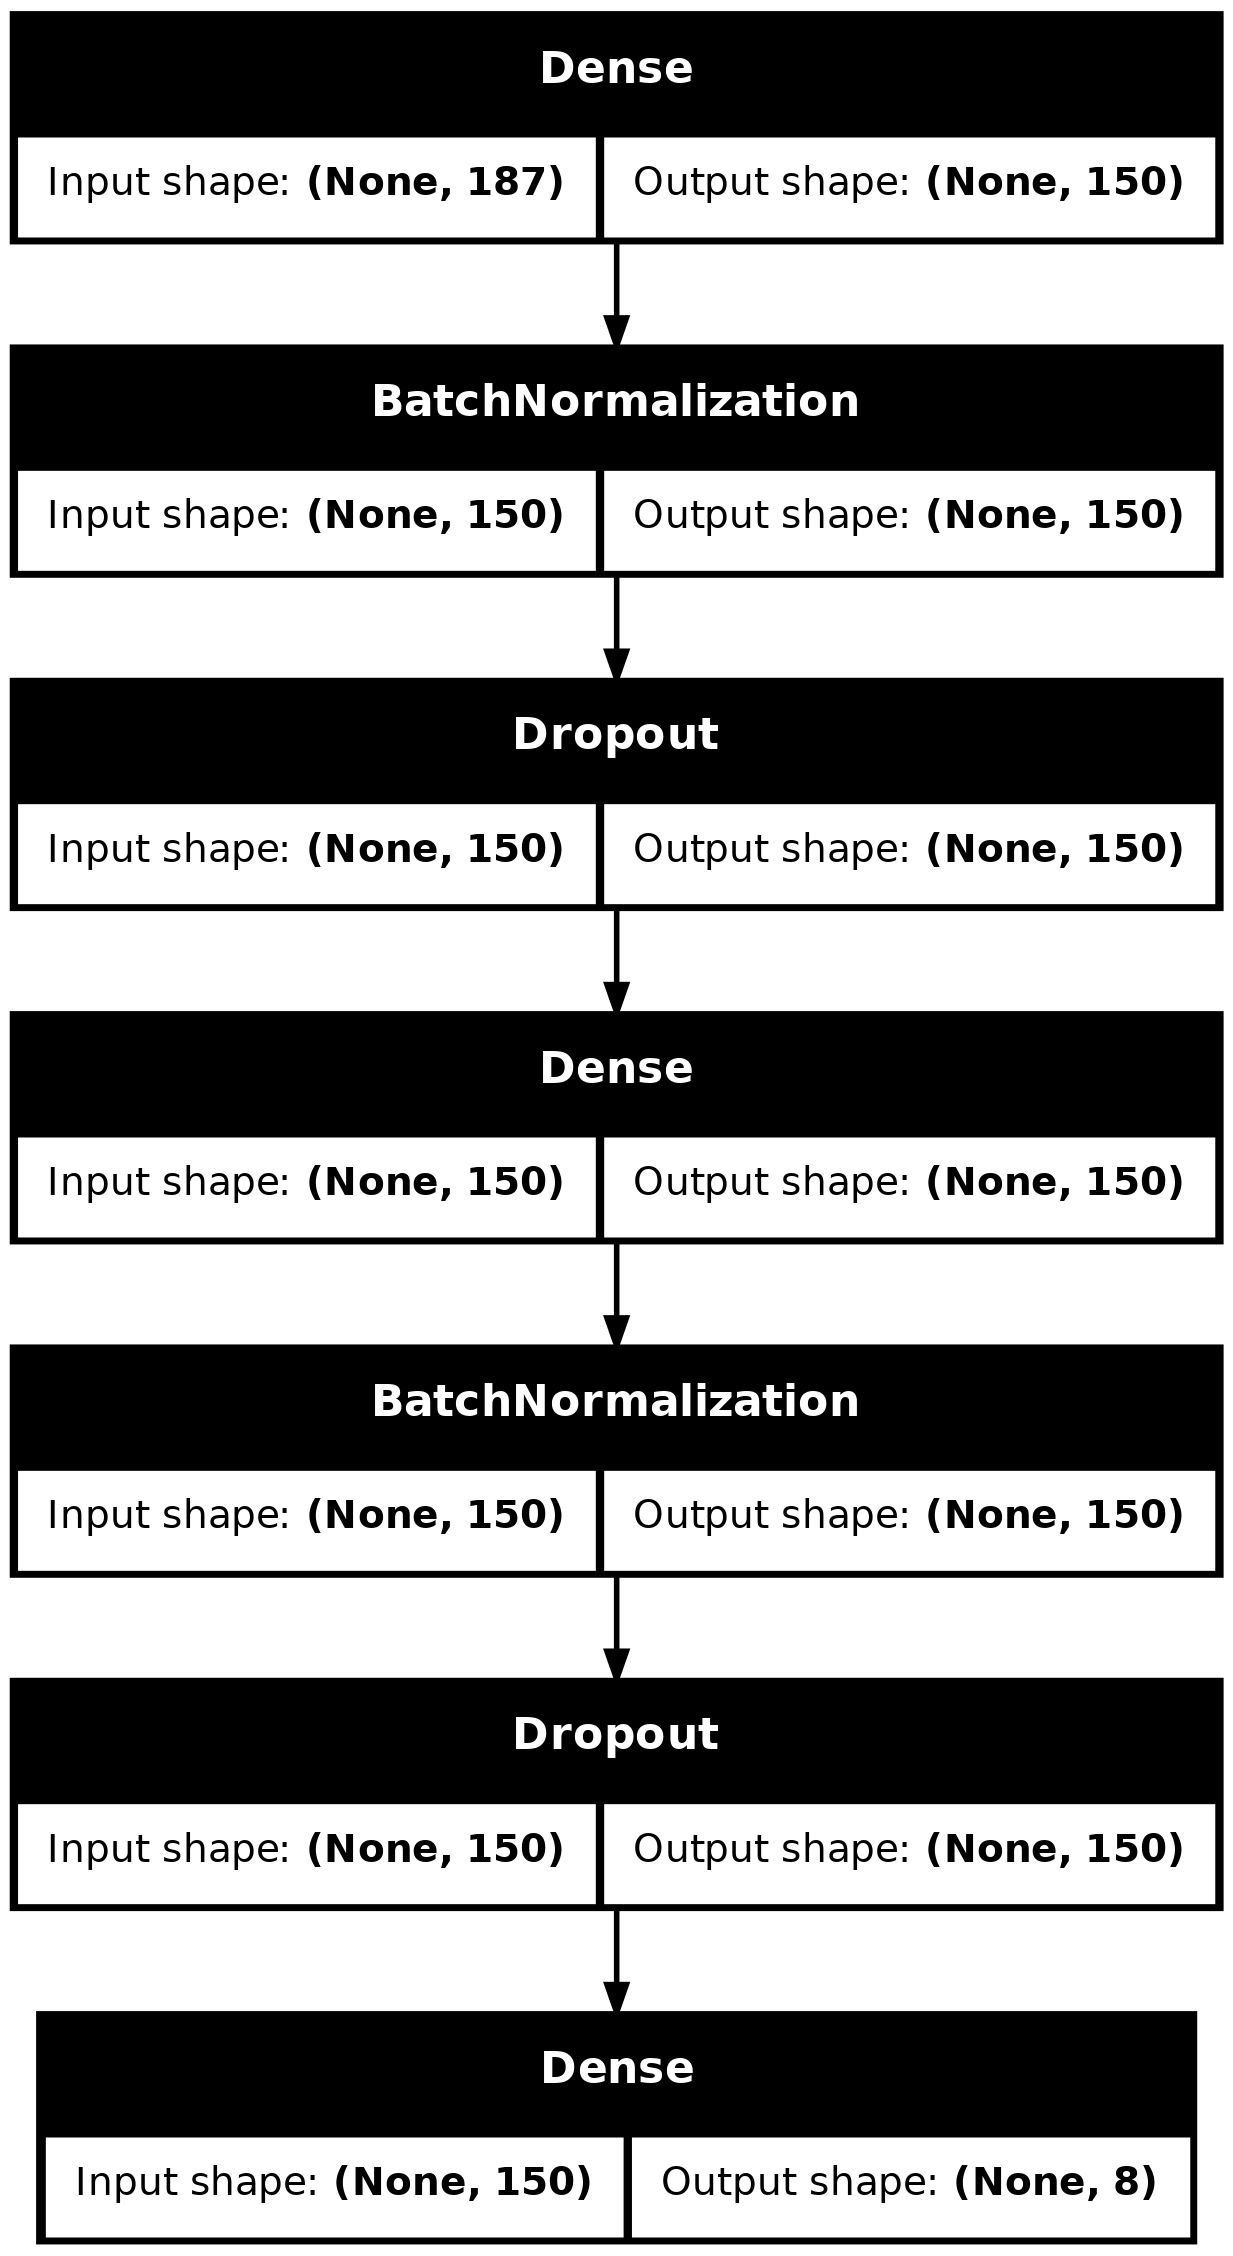

In [79]:
# load best MLP model
model = tf.keras.models.load_model('best_model_MLP_58%.keras')

# plot the model
tf.keras.utils.plot_model(model, show_shapes=True)

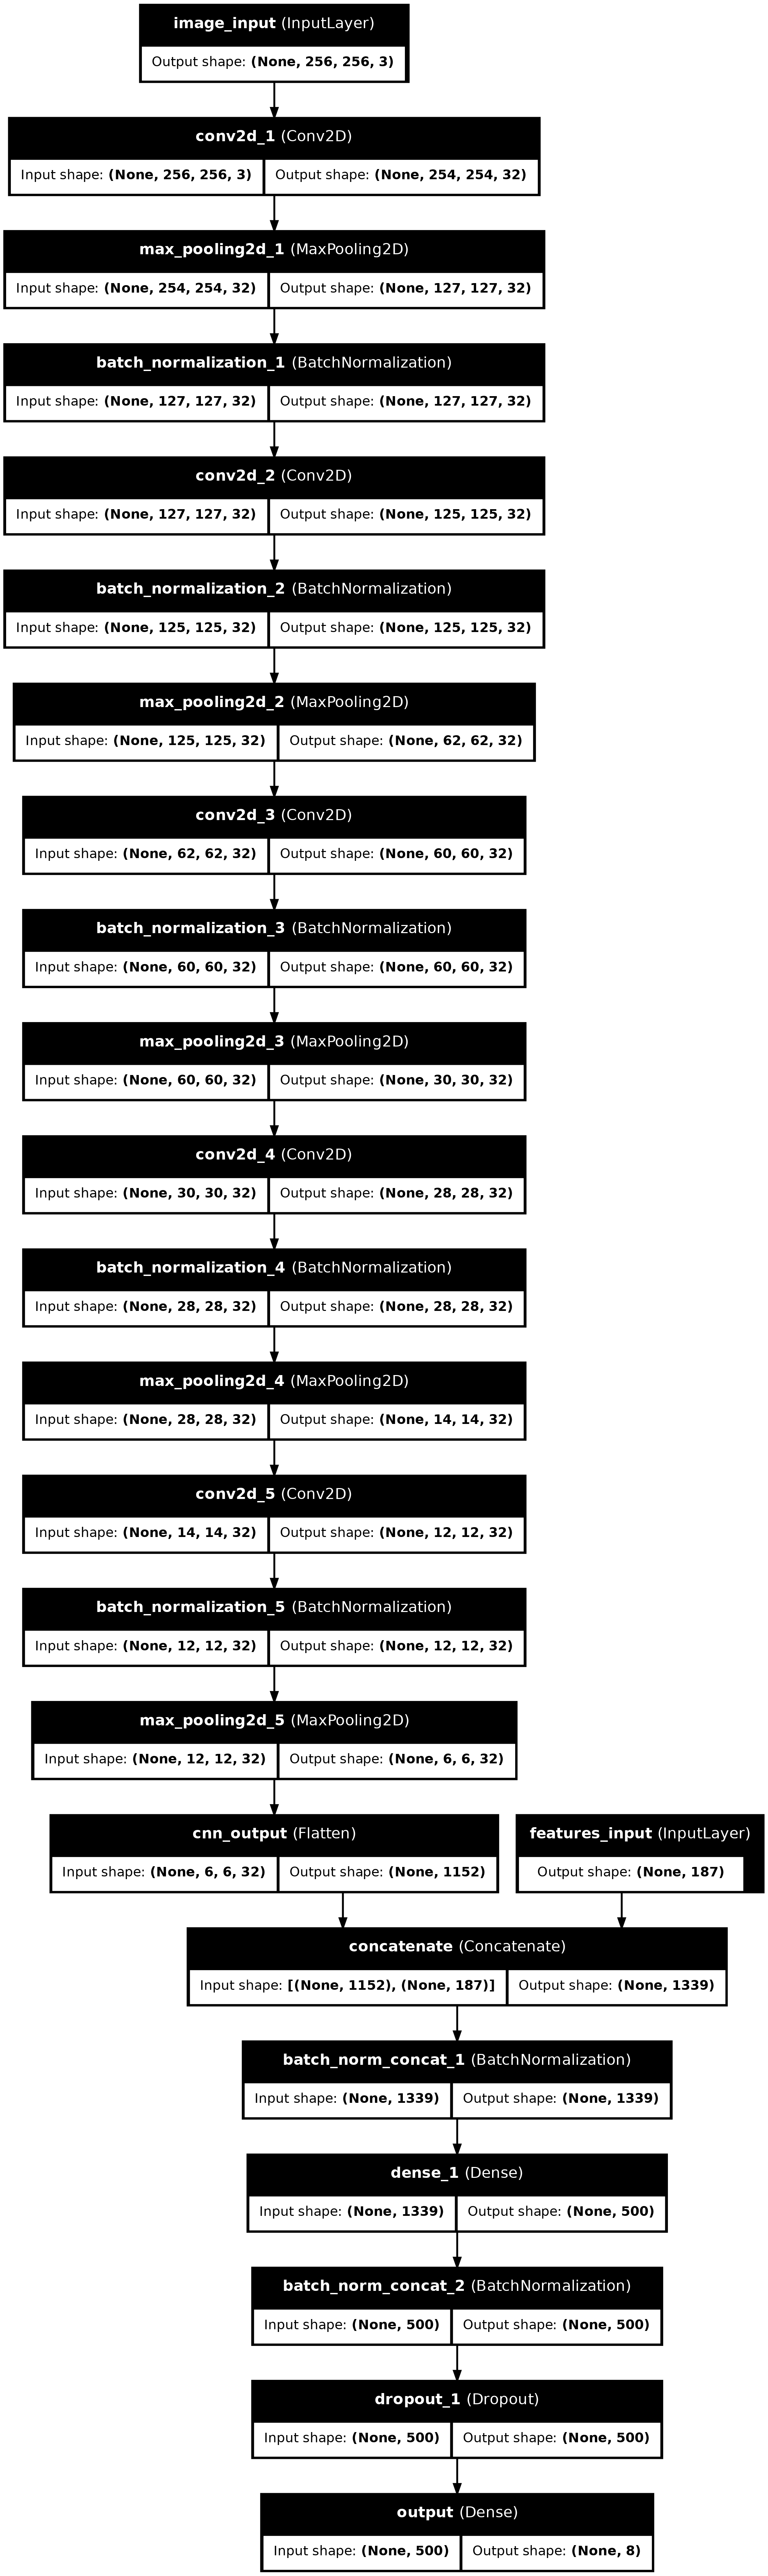

In [86]:
# Define the CNN Architecture for Image Input

# Define a height and width to which we will resize the images
height = 256 
width = 256
channels = 3

input_shape = (height, width, channels)  

# Image input
image_input = Input(shape=input_shape, name='image_input')

x = Conv2D(32, (3, 3), activation='relu', name='conv2d_1')(image_input)
x = MaxPool2D(pool_size=(2, 2), name='max_pooling2d_1')(x)
x = BatchNormalization(name='batch_normalization_1')(x)

# Repeat the pattern
for i in range(4):
    x = Conv2D(32, (3, 3), activation='relu', name=f'conv2d_{i+2}')(x)
    x = BatchNormalization(name=f'batch_normalization_{i+2}')(x)
    x = MaxPool2D(pool_size=(2, 2), name=f'max_pooling2d_{i+2}')(x)

cnn_output = Flatten(name='cnn_output')(x)

# Integrate Manually Extracted Features

dim_features = X_train.shape[1]

# Features input
features_input = Input(shape=(dim_features,), name='features_input')  # replace 'num_features' with actual size

# Concatenate the CNN output and the features input
combined = concatenate([cnn_output, features_input], name='concatenate')

# You can add more layers if needed
y = BatchNormalization(name=f'batch_norm_concat_1')(combined)
y = Dense(500, activation='relu', name='dense_1')(y)
y = BatchNormalization(name='batch_norm_concat_2')(y)
y = Dropout(0.2, name='dropout_1')(y)

final_output = Dense(8, activation='softmax', name='output')(y)

# Build and compile the model

model = Model(inputs=[image_input, features_input], outputs=[final_output])

model.compile(
    optimizer=AdamW(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Plot the model architecture
plot_model(model, show_shapes=True, show_layer_names=True)

In [87]:
num_classes = 8

def load_train_cnn(ID, train_df_scaled, TRAIN_DIR, height, width):
    # Convert ID to a string
    ID_str = tf.strings.as_string(ID)

    # Properly join path components to handle any missing slashes
    img_path = tf.strings.join([TRAIN_DIR, 'TrainImages', ID_str + '.jpg'], separator='/')
    img_raw = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img_raw, channels=3)
    img = tf.image.resize(img, [height, width])

    # Load the features
    # Ensure ID and CLASS columns are also tensors if not, convert them
    ids_tensor = tf.convert_to_tensor(train_df_scaled['ID'])
    mask = tf.equal(ids_tensor, ID)
    features_df = train_df_scaled.drop(columns=['ID', 'CLASS']).astype('float32')
    features_tensor = tf.convert_to_tensor(features_df.values)
    features = tf.boolean_mask(features_tensor, mask)
    features = tf.reshape(features, [-1])  # Flatten

    # Load the class
    class_tensor = tf.convert_to_tensor(train_df_scaled['CLASS'].values, dtype=tf.int32)
    class_label = tf.boolean_mask(class_tensor - 1, mask)
    class_label = tf.reshape(class_label, [])

    return img, features, class_label

def preprocess_output(class_label, num_classes):
    # Convert class_label to one-hot encoding safely
    return tf.one_hot(class_label, depth=num_classes)

def create_dataset(train_ids, train_df_scaled, TRAIN_DIR, height, width, num_classes):
    def load_and_preprocess(ID):
        img, features, class_label = load_train_cnn(ID, train_df_scaled, TRAIN_DIR, height, width)
        class_label = preprocess_output(class_label, num_classes)  
        return (img, features), class_label

    dataset = tf.data.Dataset.from_tensor_slices(train_ids)
    dataset = dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=1000).batch(32).prefetch(tf.data.AUTOTUNE)

    return dataset

train_ids = tf.convert_to_tensor(train_IDs)  # Convert IDs to a TensorFlow tensor
dataset = create_dataset(train_ids, train_df_scaled, TRAIN_DIR, height, width, num_classes)

In [88]:
for inputs, target in dataset.take(1):
    print("Inputs:", inputs)
    print("Target:", target)

Inputs: (<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[1.43000000e+02, 1.35000000e+02, 1.50000000e+02],
         [1.43000000e+02, 1.35000000e+02, 1.50000000e+02],
         [1.43859375e+02, 1.35859375e+02, 1.50859375e+02],
         ...,
         [1.58000000e+02, 1.53000000e+02, 1.59000000e+02],
         [1.58742188e+02, 1.53742188e+02, 1.59742188e+02],
         [1.59000000e+02, 1.54000000e+02, 1.60000000e+02]],

        [[1.42929672e+02, 1.34929672e+02, 1.49929672e+02],
         [1.42392624e+02, 1.34392624e+02, 1.49392624e+02],
         [1.43859375e+02, 1.35859375e+02, 1.50859375e+02],
         ...,
         [1.58818359e+02, 1.53818359e+02, 1.59818359e+02],
         [1.59560547e+02, 1.54560547e+02, 1.60560547e+02],
         [1.59818359e+02, 1.54818359e+02, 1.60818359e+02]],

        [[1.43611328e+02, 1.35611328e+02, 1.50611328e+02],
         [1.42775314e+02, 1.34775314e+02, 1.49775314e+02],
         [1.43859375e+02, 1.35859375e+02, 1.50859375e+02],
         ...,
 

2024-04-28 21:56:06.662080: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [90]:
# Select a CUDA device
#os.environ["CUDA_VISIBLE_DEVICES"] = "2"

# Check if there's a saved model
if os.path.exists('best_model_CNN.keras'):
    model = tf.keras.models.load_model('best_model_CNN.keras')
    print("Model loaded.")
else:
    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=10, min_lr=1e-4, verbose=1)

    model.fit(dataset,
                epochs=10,
                class_weight=class_weights_nn, 
                callbacks=[reduce_lr])

    # Save the model
    model.save('best_model_CNN.keras')

Epoch 1/10


594/594 ━━━━━━━━━━━━━━━━━━━━ 517s 869ms/step - accuracy: 0.3841 - loss: 1.6666 - learning_rate: 1.0000e-04
Epoch 2/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 519s 872ms/step - accuracy: 0.4411 - loss: 1.4996 - learning_rate: 1.0000e-04
Epoch 3/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 522s 878ms/step - accuracy: 0.4731 - loss: 1.3590 - learning_rate: 1.0000e-04
Epoch 4/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 519s 874ms/step - accuracy: 0.4951 - loss: 1.2769 - learning_rate: 1.0000e-04
Epoch 5/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 518s 872ms/step - accuracy: 0.5176 - loss: 1.1875 - learning_rate: 1.0000e-04
Epoch 6/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 511s 859ms/step - accuracy: 0.5445 - loss: 1.0933 - learning_rate: 1.0000e-04
Epoch 7/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 566s 952ms/step - accuracy: 0.5637 - loss: 1.0296 - learning_rate: 1.0000e-04
Epoch 8/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 568s 955ms/step - accuracy: 0.5822 - loss: 0.9922 - learning_rate: 1.0000e-04
Epoch 9/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 577s 970ms/step - accuracy:

In [91]:
def load_test_cnn(ID, test_df_scaled, TEST_DIR, height, width):
    ID_str = tf.strings.as_string(ID)
    img_path = tf.strings.join([TEST_DIR, 'TestImages', ID_str + '.jpg'], separator='/')
    img_raw = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img_raw, channels=3)
    img = tf.image.resize(img, [height, width])

    # Assuming test_df_scaled has a column 'ID' and other feature columns
    features_df = test_df_scaled.drop(columns=['ID']).astype('float32')
    features_tensor = tf.convert_to_tensor(features_df.values)
    ids_tensor = tf.convert_to_tensor(test_df_scaled['ID'])

    mask = tf.equal(ids_tensor, ID)
    features = tf.boolean_mask(features_tensor, mask)
    features = tf.reshape(features, [-1])

    return img, features

def create_test_dataset(test_ids, test_df_scaled, TEST_DIR, height, width):
    def load_and_preprocess(ID):
        img, features = load_test_cnn(ID, test_df_scaled, TEST_DIR, height, width)
        return (img, features)  # Make sure this is returned as a tuple

    dataset = tf.data.Dataset.from_tensor_slices(test_ids)
    dataset = dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(32).prefetch(tf.data.AUTOTUNE)

    return dataset

test_ids = tf.convert_to_tensor(test_IDs)  # Assuming test_IDs prepared similar to train_IDs
test_dataset = create_test_dataset(test_ids, test_df_scaled, TEST_DIR, height, width)

In [92]:
for images, features in test_dataset.take(1):
    print("Images shape:", images.shape)  # Expected to be (batch_size, 256, 256, 3)
    print("Features shape:", features.shape)  # Expected to be (batch_size, num_features)
    # Make a test prediction
    predictions = model.predict([images, features])
    print("Predictions shape:", predictions.shape)  # Expected to be (batch_size, num_classes)

Images shape: (32, 256, 256, 3)
Features shape: (32, 187)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
Predictions shape: (32, 8)


2024-04-28 23:36:41.899498: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [93]:
# predictions = model.predict(test_dataset) 
# predicted_classes = np.argmax(predictions, axis=1)

all_predictions = []

# Iterate over each batch in the dataset
for images, features in test_dataset:
    predictions = model.predict([images, features])
    all_predictions.extend(predictions)

# Convert list of predictions to a numpy array for further processing
all_predictions = np.array(all_predictions)
predicted_classes = np.argmax(all_predictions, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

2024-04-28 23:37:23.525765: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [94]:
# Convert the predictions
all_predictions = np.argmax(all_predictions, axis=1) + 1

# Output the predictions with their ID to a csv file
output = pd.DataFrame({'ID': test_df_scaled['ID'], 'CLASS': all_predictions})
output.to_csv('predictions_CNN.csv', index=False)
print(output.shape)

(6333, 2)
